## Loading libraries, setting up environment

We used the original repository from https://github.com/marakeby/pnet_prostate_paper but changed some scripts while debugging

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install tensorflow==1.13.1

     |████████████████████████████████| 92.6 MB 1.2 MB/s 
     |████████████████████████████████| 367 kB 47.6 MB/s 
     |████████████████████████████████| 3.2 MB 45.0 MB/s 
     |████████████████████████████████| 50 kB 6.6 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.7.0
    Uninstalling tensorflow-estimator-2.7.0:
      Successfully uninstalled tensorflow-estimator-2.7.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.7.0
    Uninstalling tensorboard-2.7.0:
      Successfully uninstalled tensorboard-2.7.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.7.0
    Uninstalling tensorflow-2.7.0:
      Successfully uninstalled tensorflow-2.7.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kapre 0.3.6 requires tensorflow>=2.0.0, but you

In [ ]:
!pip install keras==2.2.4

     |████████████████████████████████| 312 kB 4.2 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.7.0
    Uninstalling keras-2.7.0:
      Successfully uninstalled keras-2.7.0


In [ ]:
import sys
sys.path.append('/content/gdrive/MyDrive/ECBM4060/pnet_finalproject/pnet_prostate_paper')
import imp
from data.data_access import Data
from model import nn 
from copy import deepcopy 
from utils.rnd import set_random_seeds
import numpy as np
import tensorflow as tf
from keras.regularizers import l2
from model.layers_custom import f1
import math
from tensorflow.keras.metrics import Accuracy, Precision, Recall
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import StratifiedKFold
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, auc, average_precision_score,precision_recall_curve, roc_curve
import matplotlib.pyplot as plt

Using TensorFlow backend.
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

In [ ]:
################# EVALUATION CODE FOR ONE SPLIT ########################

# Compute accuracy, precision, recall, Confusion matrix, F1, AUC, AUPRC + curves for all combined model
def evaluate_per_model(y_pred_test, y_test, y_pred_score):
  cm = confusion_matrix(y_true=y_test, y_pred=y_pred_test)

  fig, ax = plt.subplots(figsize=(5, 5))
  ax.matshow(cm, cmap=plt.cm.Oranges, alpha=0.3)
  for i in range(cm.shape[0]):
      for j in range(cm.shape[1]):
          ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')
  plt.xlabel('Predictions', fontsize=18)
  plt.ylabel('Ground truth', fontsize=18)
  plt.title('Confusion Matrix', fontsize=18)
  plt.show()

  accuracy = accuracy_score(y_test, y_pred_test)
  precision = precision_score(y_test, y_pred_test)
  recall = recall_score(y_test, y_pred_test)
  f1 = f1_score(y_test, y_pred_test)  
  
  fpr, tpr, thresholds = roc_curve(y_test, y_pred_score, pos_label = 1)

  auc_score = auc(fpr, tpr)

  p, r, t = precision_recall_curve(y_test, y_pred_score)

  auprc = auc(r, p)

  print('Precision: %.3f' % precision)
  print('Recall: %.3f' % recall)
  print('Accuracy: %.3f' % accuracy)
  print('F1 Score: %.3f' % f1)
  print('AUC Score: %.3f' % auc_score)
  print('AUPRC Score: %.3f' % auprc)
  print('')

  return p, r, fpr, tpr

def evaluate_onesplit(y_test, y_pred_test_pnet, y_pred_score_pnet, y_pred_test_dense, y_pred_score_dense, y_pred_test_logreg, y_pred_score_logreg, y_pred_test_svm, y_pred_score_svm):
  
  ##### PNET #### 
  print('Evaluation of Pnet model')
  p_pnet, r_pnet, fpr_pnet, tpr_pnet = evaluate_per_model(y_pred_test_pnet, y_test, y_pred_score_pnet)
  
  ##### Dense #### 
  print('Evaluation of Dense model')
  p_dense, r_dense, fpr_dense, tpr_dense = evaluate_per_model(y_pred_test_dense, y_test, y_pred_score_dense)
  
  ##### Logistic Regression #### 
  print('Evaluation of Logistic regression model')
  p_logreg, r_logreg, fpr_logreg, tpr_logreg = evaluate_per_model(y_pred_test_logreg, y_test, y_pred_score_logreg)
  
  ##### Linear SVM #### 
  print('Evaluation of Linear SVM model')
  p_svm, r_svm, fpr_svm, tpr_svm = evaluate_per_model(y_pred_test_svm, y_test, y_pred_score_svm)
 
  print('PRC curve for all models')
  fig, ax = plt.subplots(figsize=(5, 5))
  plt.plot(r_pnet, p_pnet, label='P-NET')
  plt.plot(r_dense, p_dense, label='Dense')   
  plt.plot(r_logreg, p_logreg, label='Logistic regression') 
  plt.plot(r_svm, p_svm, label='Linear SVM') 
  plt.xlabel('Recall', fontsize=18)
  plt.ylabel('Precision', fontsize=18)
  plt.title('PRC', fontsize=18)
  plt.legend()
  plt.show()


  fig, ax = plt.subplots(figsize=(5, 5))
  plt.plot(fpr_pnet, tpr_pnet, label='P-NET')
  plt.plot(fpr_dense, tpr_dense, label='Dense')   
  plt.plot(fpr_logreg, tpr_logreg, label='Logistic regression') 
  plt.plot(fpr_svm, tpr_svm, label='Linear SVM')   
  plt.xlabel('False Positive Rate', fontsize=18)
  plt.ylabel('True Positive Rate', fontsize=18)
  plt.title('FPR TPR curve', fontsize=18)
  plt.legend()
  plt.show()

# One split

## Load data

In [ ]:
# Load data
params_file_full_onesplit_pnet = '/content/gdrive/My Drive/ECBM4060/pnet_finalproject/pnet_prostate_paper/train/params/P1000/pnet/onsplit_average_reg_10_tanh_large_testing.py'

In [ ]:
params_onesplit_pnet = imp.load_source('onsplit_average_reg_10_tanh_large_testing',params_file_full_onesplit_pnet)

In [ ]:
params_onesplit_pnet.data

[{'id': 'ALL',
  'params': {'balanced_data': False,
   'cnv_levels': 3,
   'combine_type': 'union',
   'data_type': ['mut_important', 'cnv_del', 'cnv_amp'],
   'drop_AR': False,
   'mut_binary': True,
   'selected_genes': 'tcga_prostate_expressed_genes_and_cancer_genes.csv',
   'training_split': 0,
   'use_coding_genes_only': True},
  'type': 'prostate_paper'}]

In [ ]:
data_params_onesplit_pnet = params_onesplit_pnet.data[0]
# Create dataset
data_onesplit = Data(**data_params_onesplit_pnet)

In [ ]:
x_train_onesplit, x_validate_onesplit, x_test_onesplit, y_train_onesplit, y_validate_onesplit, y_test_onesplit, info_train_onesplit, info_validate_onesplit, info_test_onesplit, cols_onesplit = data_onesplit.get_train_validate_test()

In [ ]:
print('Shape of x_train: {}'.format(np.shape(x_train_onesplit)))
print('Shape of y_train: {}'.format(np.shape(y_train_onesplit)))

Shape of x_train: (807, 27687)
Shape of y_train: (807, 1)


## Build and train PNET Model

In [ ]:
params_onesplit_pnet.models[0]

{'id': 'P-net',
 'params': {'build_fn': <function model.builders.prostate_models.build_pnet2>,
  'feature_importance': 'deepexplain_deeplift',
  'fitting_params': {'batch_size': 50,
   'class_weight': {0: 0.75, 1: 1.5},
   'debug': False,
   'early_stop': False,
   'epoch': 300,
   'lr': 0.001,
   'max_f1': True,
   'monitor': 'val_o6_f1',
   'n_outputs': 6,
   'prediction_output': 'average',
   'reduce_lr': False,
   'reduce_lr_after_nepochs': {'drop': 0.25, 'epochs_drop': 50},
   'samples_per_epoch': 10,
   'save_gradient': False,
   'save_name': 'pnet',
   'select_best_model': False,
   'shuffle': True,
   'verbose': 2},
  'model_params': {'activation': 'tanh',
   'add_unk_genes': False,
   'attention': False,
   'data_params': {'id': 'ALL',
    'params': {'balanced_data': False,
     'cnv_levels': 3,
     'combine_type': 'union',
     'data_type': ['mut_important', 'cnv_del', 'cnv_amp'],
     'drop_AR': False,
     'mut_binary': True,
     'selected_genes': 'tcga_prostate_expressed

In [ ]:
m_onesplit_pnet = params_onesplit_pnet.models[0]
model_params_onesplit_pnet = deepcopy(m_onesplit_pnet)
set_random_seeds(random_seed=10)

In [ ]:
model_onesplit_pnet = nn.Model(**model_params_onesplit_pnet['params'])

{0: 0.75, 1: 1.5}


In [ ]:
model_onesplit_pnet = model_onesplit_pnet.fit(x_train_onesplit, y_train_onesplit, x_validate_onesplit, y_validate_onesplit)

{'id': 'ALL', 'type': 'prostate_paper', 'params': {'data_type': ['mut_important', 'cnv_del', 'cnv_amp'], 'drop_AR': False, 'cnv_levels': 3, 'mut_binary': True, 'balanced_data': False, 'combine_type': 'union', 'use_coding_genes_only': True, 'selected_genes': 'tcga_prostate_expressed_genes_and_cancer_genes.csv', 'training_split': 0}}
n_hidden_layers 5


(1011, 27687)
(1011, 1)
(1011,)
(27687,)
input dimension 27687 self.units 9229
n_inputs_per_node 3.0
self.kernel_initializer <keras.regularizers.L1L2 object at 0x7f684f698ed0> <keras.initializers.VarianceScaling object at 0x7f684f6180d0> <keras.regularizers.L1L2 object at 0x7f684f698ed0>
input dimensions (?, 27687)
layer # 0
pathways 1387
genes 9275
filtered_map (9229, 0)
filtered_map (9229, 0)
filtered_map (9229, 0)
layer # 1
pathways 1066
genes 1399
filtered_map (1387, 0)
filtered_map (1387, 0)
filtered_map (1387, 0)
layer # 2
pathways 447
genes 1068
filtered_map (1066, 0)
filtered_map (1066, 0)
filtered_map (1066, 0)
layer # 3
pathways 147
genes 448
filtered_map (447, 0)
filtered_map (447, 0)
filtered_map (447, 0)
layer # 4
pathways 26
genes 147
filtered_map (147, 0)
filtered_map (147, 0)
filtered_map (147, 0)
layer # 5
pathways 1
genes 26
filtered_map (26, 0)
filtered_map (26, 0)
filtered_map (26, 0)
original dropout [0.5, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
dropout range(1, 6) [0.5, 0.1

Instructions for updating:
Use tf.compat.v1.graph_util.extract_sub_graph


h0_9/Tanh
h1_9/Tanh
h2_9/Tanh
h3_9/Tanh
h4_9/Tanh
h5_9/Tanh
o6_9/Sigmoid
ins [<tf.Tensor 'h0_9/BiasAdd:0' shape=(?, 9229) dtype=float32>, <tf.Tensor 'h1_9/BiasAdd:0' shape=(?, 1387) dtype=float32>, <tf.Tensor 'h2_9/BiasAdd:0' shape=(?, 1066) dtype=float32>, <tf.Tensor 'h3_9/BiasAdd:0' shape=(?, 447) dtype=float32>, <tf.Tensor 'h4_9/BiasAdd:0' shape=(?, 147) dtype=float32>, <tf.Tensor 'h5_9/BiasAdd:0' shape=(?, 26) dtype=float32>, <tf.Tensor 'o_linear6_9/BiasAdd:0' shape=(?, 1) dtype=float32>]
Tensor("inputs_9:0", shape=(?, 27687), dtype=float32) <class 'numpy.ndarray'> (1, 27687) float64
Tensor("inputs_9:0", shape=(?, 27687), dtype=float32) <class 'numpy.ndarray'> (1, 27687) float64
Tensor("inputs_9:0", shape=(?, 27687), dtype=float32) <class 'numpy.ndarray'> (807, 27687) float64
attributions (807, 27687)
gradients.shape (807, 27687)
feature_weights.shape (27687,)
feature_weights min max -3.0236878 44.386604
layer # 1, layer name h0,  output name -1
graph <tensorflow.python.framework.o

## Build and train Dense Model

In [ ]:
inputs = tf.keras.Input(shape=(x_train_onesplit.shape[1],), dtype='float32', name='inputs')
layer1 = tf.keras.layers.Dense(units = int(np.ceil(float(71009) / float(x_train_onesplit.shape[1]))), activation='tanh', name="layer1", kernel_regularizer=l2(0.01))(inputs)# , input_shape=(x.shape[1],)
outputs = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(layer1) 
model_onesplit_dense = tf.keras.Model(inputs=inputs, outputs=outputs)


def get_lr_metric(optimizer):  # printing the value of the learning rate
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

optimizer = tf.keras.optimizers.Adam()  
lr_metric = get_lr_metric(optimizer)

model_onesplit_dense.compile(optimizer=optimizer,
                  loss='binary_crossentropy', metrics=[f1, Precision(), Recall(), lr_metric])

model_onesplit_dense.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 27687)             0         
_________________________________________________________________
layer1 (Dense)               (None, 3)                 83064     
_________________________________________________________________
output (Dense)               (None, 1)                 4         
Total params: 83,068
Trainable params: 83,068
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Train
def scheduler(epoch):
    # Decrease the learning rate to 1/4 every 50 epochs
    initial_lr = 0.001
    drop = 0.25
    epochs_drop = 50
    lrate = initial_lr * math.pow(drop, math.floor((1+epoch)/epochs_drop))   
    return lrate

lrate = tf.keras.callbacks.LearningRateScheduler(scheduler)

model_onesplit_dense.fit(
    x_train_onesplit,
    y_train_onesplit,
    batch_size = 50,
    epochs = 300,
    verbose = 2,
    shuffle=True,
    callbacks=[lrate],
    class_weight= 'auto',
    )


Epoch 1/300
 - 1s - loss: 0.6781 - f1: 0.5161 - precision: 0.5382 - recall: 0.5301 - lr: 0.0010
Epoch 2/300
 - 0s - loss: 0.5504 - f1: 0.8476 - precision: 0.8346 - recall: 0.8534 - lr: 0.0010
Epoch 3/300
 - 0s - loss: 0.4984 - f1: 0.9107 - precision: 0.9111 - recall: 0.9248 - lr: 0.0010
Epoch 4/300
 - 0s - loss: 0.4624 - f1: 0.9438 - precision: 0.9611 - recall: 0.9286 - lr: 0.0010
Epoch 5/300
 - 0s - loss: 0.4391 - f1: 0.9506 - precision: 0.9623 - recall: 0.9586 - lr: 0.0010
Epoch 6/300
 - 0s - loss: 0.4171 - f1: 0.9609 - precision: 0.9700 - recall: 0.9737 - lr: 0.0010
Epoch 7/300
 - 0s - loss: 0.4019 - f1: 0.9777 - precision: 0.9738 - recall: 0.9774 - lr: 0.0010
Epoch 8/300
 - 0s - loss: 0.3888 - f1: 0.9820 - precision: 0.9848 - recall: 0.9774 - lr: 0.0010
Epoch 9/300
 - 0s - loss: 0.3750 - f1: 0.9851 - precision: 0.9924 - recall: 0.9774 - lr: 0.0010
Epoch 10/300
 - 0s - loss: 0.3636 - f1: 0.9908 - precision: 1.0000 - recall: 0.9812 - lr: 0.0010
Epoch 11/300
 - 0s - loss: 0.3521 - f1:

## Build and train Logistic Regression

In [ ]:
# instantiate the model
model_onesplit_logreg = LogisticRegression()

# fit the model with data
model_onesplit_logreg.fit(x_train_onesplit,y_train_onesplit)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

## Build and train Linear SVM

In [ ]:
params_file_full_onesplit_svm = '/content/gdrive/My Drive/ECBM4060/pnet_finalproject/pnet_prostate_paper/train/params/P1000/ML_params_search/onesplit_ML_params_search_svm_linear.py'
params_onesplit_svm = imp.load_source('onesplit_ML_params_search_svm_linear', params_file_full_onesplit_svm)

/content/gdrive/My Drive/ECBM4060/pnet_finalproject/pnet_prostate_paper/train/params/P1000
0


In [ ]:
# instantiate the model
p = params_onesplit_svm.models[1]["params"]
svm = LinearSVC(max_iter=5000, **p)
model_onesplit_svm = CalibratedClassifierCV(svm) 
# fit the model with data
model_onesplit_svm.fit(x_train_onesplit,y_train_onesplit)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example u

CalibratedClassifierCV(base_estimator=LinearSVC(C=0.01,
                                                class_weight={0: 0.75, 1: 1.5},
                                                max_iter=5000))

## Evaluation

In [ ]:
############# Predictions

# Pnet
y_pred_test_onesplit_pnet = model_onesplit_pnet.predict(x_test_onesplit)
y_pred_score_onesplit_pnet = model_onesplit_pnet.predict_proba(x_test_onesplit)[:,1]

# Dense
# Getting prediction probabilities
y_pred_score_onesplit_dense = model_onesplit_dense.predict(x_test_onesplit)
# Getting predictions
y_pred_test_onesplit_dense = np.array(list(map(int,y_pred_score_onesplit_dense > .5)))

# Logistic regression
y_pred_test_onesplit_logreg = model_onesplit_logreg.predict(x_test_onesplit)
y_pred_score_onesplit_logreg = model_onesplit_logreg.predict_proba(x_test_onesplit)[:,1]

# Linear SVM
y_pred_test_onesplit_svm = model_onesplit_svm.predict(x_test_onesplit)
y_pred_score_onesplit_svm = model_onesplit_svm.predict_proba(x_test_onesplit)[:,1]

(102, 1)
(102, 1)
(102, 2)


Evaluation of Pnet model


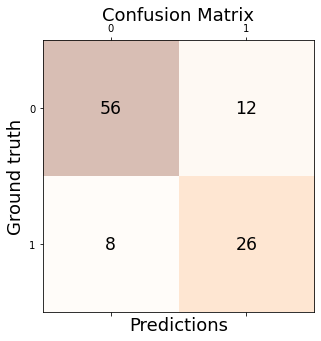

Precision: 0.684
Recall: 0.765
Accuracy: 0.804
F1 Score: 0.722
AUC Score: 0.912
AUPRC Score: 0.861

Evaluation of Dense model


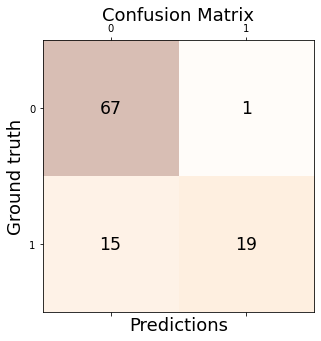

Precision: 0.950
Recall: 0.559
Accuracy: 0.843
F1 Score: 0.704
AUC Score: 0.917
AUPRC Score: 0.878

Evaluation of Logistic regression model


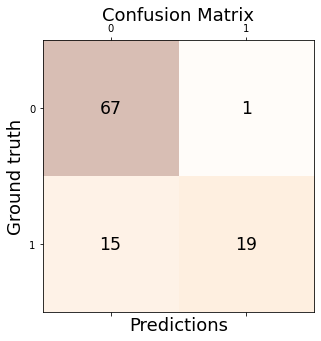

Precision: 0.950
Recall: 0.559
Accuracy: 0.843
F1 Score: 0.704
AUC Score: 0.913
AUPRC Score: 0.879

Evaluation of Linear SVM model


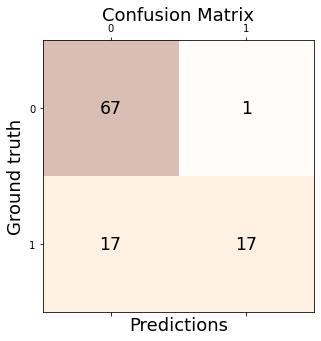

Precision: 0.944
Recall: 0.500
Accuracy: 0.824
F1 Score: 0.654
AUC Score: 0.906
AUPRC Score: 0.864

PRC curve for all models


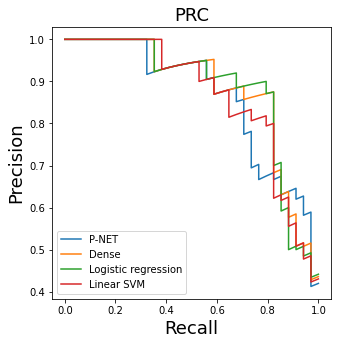

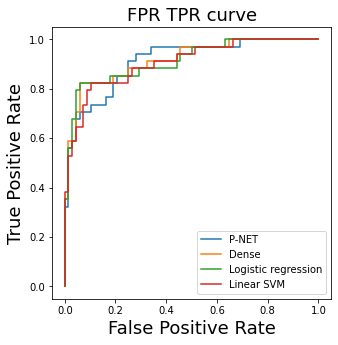

In [ ]:
evaluate_onesplit(y_test_onesplit, y_pred_test_onesplit_pnet, y_pred_score_onesplit_pnet, y_pred_test_onesplit_dense, y_pred_score_onesplit_dense, y_pred_test_onesplit_logreg, y_pred_score_onesplit_logreg, y_pred_test_onesplit_svm, y_pred_score_onesplit_svm)

# External validation

In [ ]:
################# EVALUATION CODE FOR EXTERNAL VALIDATION SET ########################

# Compute Confusion matrix

def evaluate_external(y_pred_test1, y_test1, y_pred_score1, y_pred_test2, y_test2, y_pred_score2):

  cm1 = confusion_matrix(y_true=y_test1, y_pred=y_pred_test1)
  cm2 = confusion_matrix(y_true=y_test2, y_pred=y_pred_test2)

  cm = np.array([[round(cm2[0,0]/(cm2[0,0]+cm2[0,1])*100,2), round(cm2[0,1]/(cm2[0,0]+cm2[0,1])*100,2)],
        [round(cm1[1,0]/(cm1[1,0]+cm1[1,1])*100,2), round(cm1[1,1]/(cm1[1,0]+cm1[1,1])*100,2)]])
  
  fig, ax = plt.subplots(figsize=(5, 5))
  ax.matshow(cm, cmap=plt.cm.Oranges, alpha=0.3)
  for i in range(cm.shape[0]):
      for j in range(cm.shape[1]):
          ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')
  
  plt.xlabel('Predictions', fontsize=18)
  plt.ylabel('Ground truth', fontsize=18)
  plt.title('Confusion Matrix', fontsize=18)
  plt.show()

  return

## Load data

In [ ]:
params_file_full_exval_pnet = '/content/gdrive/My Drive/ECBM4060/pnet_finalproject/pnet_prostate_paper/train/params/P1000/external_validation/pnet_validation.py'

In [ ]:
params_exval_pnet = imp.load_source('pnet_validation',params_file_full_exval_pnet)

In [ ]:
params_exval_pnet.data

[{'id': 'ALL',
  'params': {'balanced_data': False,
   'cnv_levels': 3,
   'combine_type': 'union',
   'data_type': ['mut_important', 'cnv'],
   'drop_AR': False,
   'mut_binary': True,
   'selected_genes': 'tcga_prostate_expressed_genes_and_cancer_genes.csv',
   'training_split': 0,
   'use_coding_genes_only': True},
  'type': 'prostate_paper'}]

In [ ]:
data_params_exval_pnet = params_exval_pnet.data[0]
# Create dataset
data = Data(**data_params_exval_pnet)

In [ ]:
x_train_exval, y_train_exval, info_train_exval, cols_train_exval = data.get_data()

In [ ]:
data_types_exval = cols_train_exval.get_level_values(1).unique()

In [ ]:
# Divide the training set into two balanced training sets. Later we will train 2 models and combine their outputs.
index_pos_exval = np.where(y_train_exval == 1)[0]
index_neg_exval = np.where(y_train_exval == 0)[0]
n_pos_exval = index_pos_exval.shape[0]

# Training set 1
# select the same number of samples as the positive class
index_neg1_exval = index_neg_exval[0:n_pos_exval]

x_train_pos_exval = x_train_exval[index_pos_exval, :]
x_train_neg_exval = x_train_exval[index_neg1_exval, :]
x_train1_exval = np.concatenate((x_train_pos_exval, x_train_neg_exval))

y_train_pos_exval = y_train_exval[index_pos_exval, :]
y_train_neg_exval = y_train_exval[index_neg1_exval, :]
y_train1_exval = np.concatenate((y_train_pos_exval, y_train_neg_exval))

info_train_pos_exval = info_train_exval[index_pos_exval]
info_train_neg1_exval = info_train_exval[index_neg1_exval]
info_train1_exval = np.concatenate((info_train_pos_exval, info_train_neg1_exval))

# Training set 2
index_neg2_exval = index_neg_exval[n_pos_exval:]
x_train_neg2_exval = x_train_exval[index_neg2_exval, :]
x_train2_exval = np.concatenate((x_train_pos_exval, x_train_neg2_exval))

y_train_neg2_exval = y_train_exval[index_neg2_exval, :]
y_train2_exval = np.concatenate((y_train_pos_exval, y_train_neg2_exval))

info_train_pos_exval = info_train_exval[index_pos_exval]
info_train_neg2_exval = info_train_exval[index_neg2_exval]
info_train2_exval = np.concatenate((info_train_pos_exval, info_train_neg2_exval))

print('Train sets shape: ')
print(x_train1_exval.shape, y_train1_exval.shape, info_train1_exval.shape, cols_train_exval.shape, sum(y_train1_exval))
print(x_train2_exval.shape, y_train2_exval.shape, info_train2_exval.shape, cols_train_exval.shape, sum(y_train2_exval))

Train sets shape: 
(666, 18458) (666, 1) (666,) (18458,) [333]
(678, 18458) (678, 1) (678,) (18458,) [333]


In [ ]:
from pipeline.train_validate import get_validation_primary, get_validation_metastatic

# External validation: 2 datasets
x_test_mets, y_test_mets, info_test_mets, cols_test_mets = get_validation_metastatic(cols_train_exval, cnv_split = False)
x_test_primary, y_test_primary, info_test_primary, cols_test_primary = get_validation_primary(cols_train_exval, cnv_split = False)

validation x
              BPGM           GNA14       ...      EPS15          ATAD2B     
        gene_final  cnv gene_final  cnv  ... gene_final  cnv gene_final  cnv
MO_1093        0.0  1.0        0.0  0.0  ...        0.0  0.0        0.0  0.0
MO_1240        0.0  1.0        0.0  0.0  ...        0.0  0.0        0.0  0.0
TP_2096        0.0  1.0        0.0  0.0  ...        0.0 -1.0        0.0  0.0
MO_1510        0.0  1.0        0.0  0.0  ...        0.0  0.0        0.0  0.0
MO_1490        0.0  1.0        0.0  0.0  ...        0.0  0.0        0.0  0.0

[5 rows x 18458 columns]
x validation shape (40, 18458)


In [ ]:
print('Test set shape: ')
print(x_test_mets.shape, y_test_mets.shape, info_test_mets.shape, cols_test_mets.shape)
print(x_test_primary.shape, y_test_primary.shape, info_test_primary.shape, cols_test_primary.shape)

Test set shape: 
(40, 18458) (40,) (40, 0) (18458,)
(130, 18458) (130,) (130, 0) (18458,)


## Build and train Pnet Model

In [ ]:
m_exval_pnet1 = params_exval_pnet.models[0]
m_exval_pnet2 = params_exval_pnet.models[0]

model_params_exval_pnet1 = deepcopy(m_exval_pnet1)
model_params_exval_pnet2 = deepcopy(m_exval_pnet2)

set_random_seeds(random_seed=10)

In [ ]:
model_exval_pnet1 = nn.Model(**model_params_exval_pnet1['params'])
model_exval_pnet2 = nn.Model(**model_params_exval_pnet2['params'])

auto
auto


In [ ]:
model_exval_pnet1 = model_exval_pnet1.fit(x_train1_exval, y_train1_exval)

{'id': 'ALL', 'type': 'prostate_paper', 'params': {'data_type': ['mut_important', 'cnv'], 'drop_AR': False, 'cnv_levels': 3, 'mut_binary': True, 'balanced_data': False, 'combine_type': 'union', 'use_coding_genes_only': True, 'selected_genes': 'tcga_prostate_expressed_genes_and_cancer_genes.csv', 'training_split': 0}}
n_hidden_layers 5


(1011, 18458)
(1011, 1)
(1011,)
(18458,)
input dimension 18458 self.units 9229
n_inputs_per_node 2.0
self.kernel_initializer <keras.regularizers.L1L2 object at 0x7ff845079a10> <keras.initializers.VarianceScaling object at 0x7ff84dd4fe50> <keras.regularizers.L1L2 object at 0x7ff845079a10>
input dimensions (?, 18458)
layer # 0
pathways 1387
genes 9275
filtered_map (9229, 0)
filtered_map (9229, 0)
filtered_map (9229, 0)
layer # 1
pathways 1066
genes 1399
filtered_map (1387, 0)
filtered_map (1387, 0)
filtered_map (1387, 0)
layer # 2
pathways 447
genes 1068
filtered_map (1066, 0)
filtered_map (1066, 0)
filtered_map (1066, 0)
layer # 3
pathways 147
genes 448
filtered_map (447, 0)
filtered_map (447, 0)
filtered_map (447, 0)
layer # 4
pathways 26
genes 147
filtered_map (147, 0)
filtered_map (147, 0)
filtered_map (147, 0)
layer # 5
pathways 1
genes 26
filtered_map (26, 0)
filtered_map (26, 0)
filtered_map (26, 0)
original dropout [0.5, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
dropout range(1, 6) [0.5, 0.1

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined a

    accuracy  precision        f1  recall    th
0        0.5        0.5  0.666667     1.0  0.10
1        0.5        0.5  0.666667     1.0  0.11
2        0.5        0.5  0.666667     1.0  0.12
3        0.5        0.5  0.666667     1.0  0.13
4        0.5        0.5  0.666667     1.0  0.14
..       ...        ...       ...     ...   ...
75       0.5        0.0  0.000000     0.0  0.85
76       0.5        0.0  0.000000     0.0  0.86
77       0.5        0.0  0.000000     0.0  0.87
78       0.5        0.0  0.000000     0.0  0.88
79       0.5        0.0  0.000000     0.0  0.89

[80 rows x 5 columns]
layer # 0, layer name inputs,  output name -1
graph <tensorflow.python.framework.ops.Graph object at 0x7ff85b0b1810>
inputs
input dimension 18458 self.units 9229
n_inputs_per_node 2.0
self.kernel_initializer None <keras.initializers.VarianceScaling object at 0x7ff83fecbcd0> None
input dimensions (?, 18458)
inputs
model.inputs [<tf.Tensor 'inputs_10:0' shape=(?, 18458) dtype=float32>]
model y Tensor

In [ ]:
model_exval_pnet2 = model_exval_pnet2.fit(x_train2_exval, y_train2_exval)

{'id': 'ALL', 'type': 'prostate_paper', 'params': {'data_type': ['mut_important', 'cnv'], 'drop_AR': False, 'cnv_levels': 3, 'mut_binary': True, 'balanced_data': False, 'combine_type': 'union', 'use_coding_genes_only': True, 'selected_genes': 'tcga_prostate_expressed_genes_and_cancer_genes.csv', 'training_split': 0}}
n_hidden_layers 5


(1011, 18458)
(1011, 1)
(1011,)
(18458,)
input dimension 18458 self.units 9229
n_inputs_per_node 2.0
self.kernel_initializer <keras.regularizers.L1L2 object at 0x7ff83cbc8850> <keras.initializers.VarianceScaling object at 0x7ff83cbc76d0> <keras.regularizers.L1L2 object at 0x7ff83cbc8850>
input dimensions (?, 18458)
layer # 0
pathways 1387
genes 9275
filtered_map (9229, 0)
filtered_map (9229, 0)
filtered_map (9229, 0)
layer # 1
pathways 1066
genes 1399
filtered_map (1387, 0)
filtered_map (1387, 0)
filtered_map (1387, 0)
layer # 2
pathways 447
genes 1068
filtered_map (1066, 0)
filtered_map (1066, 0)
filtered_map (1066, 0)
layer # 3
pathways 147
genes 448
filtered_map (447, 0)
filtered_map (447, 0)
filtered_map (447, 0)
layer # 4
pathways 26
genes 147
filtered_map (147, 0)
filtered_map (147, 0)
filtered_map (147, 0)
layer # 5
pathways 1
genes 26
filtered_map (26, 0)
filtered_map (26, 0)
filtered_map (26, 0)
original dropout [0.5, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
dropout range(1, 6) [0.5, 0.1

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined a

    accuracy  precision        f1  recall    th
0    0.49115    0.49115  0.658754     1.0  0.10
1    0.49115    0.49115  0.658754     1.0  0.11
2    0.49115    0.49115  0.658754     1.0  0.12
3    0.49115    0.49115  0.658754     1.0  0.13
4    0.49115    0.49115  0.658754     1.0  0.14
..       ...        ...       ...     ...   ...
75   0.50885    0.00000  0.000000     0.0  0.85
76   0.50885    0.00000  0.000000     0.0  0.86
77   0.50885    0.00000  0.000000     0.0  0.87
78   0.50885    0.00000  0.000000     0.0  0.88
79   0.50885    0.00000  0.000000     0.0  0.89

[80 rows x 5 columns]
layer # 0, layer name inputs,  output name -1
graph <tensorflow.python.framework.ops.Graph object at 0x7ff85b0b1810>
inputs
input dimension 18458 self.units 9229
n_inputs_per_node 2.0
self.kernel_initializer None <keras.initializers.VarianceScaling object at 0x7ff83aca1f50> None
input dimensions (?, 18458)
inputs
model.inputs [<tf.Tensor 'inputs_18:0' shape=(?, 18458) dtype=float32>]
model y Tensor

## Evaluation

In [ ]:
# METS

# Model 1
y_pred_test1_mets_pnet = model_exval_pnet1.predict(x_test_mets)
y_pred_score1_mets_pnet = model_exval_pnet1.predict_proba(x_test_mets)[:,1]

# Model 2
y_pred_test2_mets_pnet = model_exval_pnet2.predict(x_test_mets)
y_pred_score2_mets_pnet = model_exval_pnet2.predict_proba(x_test_mets)[:,1]

# Combining both
y_pred_test_scores_mets_pnet = (y_pred_score1_mets_pnet + y_pred_score2_mets_pnet) / 2.
y_pred_test_mets_pnet = y_pred_test_scores_mets_pnet > 0.5

(40, 1)
(40, 1)
(40, 2)
(40, 1)
(40, 1)
(40, 2)


In [ ]:
# Primary

# Model 1
y_pred_test1_primary_pnet = model_exval_pnet1.predict(x_test_primary)
y_pred_score1_primary_pnet = model_exval_pnet1.predict_proba(x_test_primary)[:,1]

# Model 2
y_pred_test2_primary_pnet = model_exval_pnet2.predict(x_test_primary)
y_pred_score2_primary_pnet = model_exval_pnet2.predict_proba(x_test_primary)[:,1]

# Combining both
y_pred_test_scores_primary_pnet = (y_pred_score1_primary_pnet + y_pred_score2_primary_pnet) / 2.
y_pred_test_primary_pnet = y_pred_test_scores_primary_pnet > 0.5

(130, 1)
(130, 1)
(130, 2)
(130, 1)
(130, 1)
(130, 2)


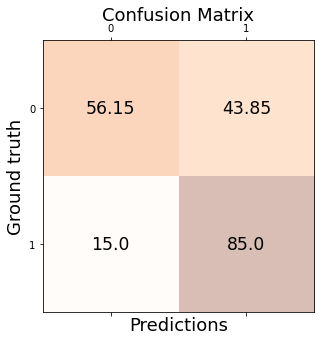

In [ ]:
evaluate_external(y_pred_test_mets_pnet, y_test_mets, y_pred_test_scores_mets_pnet, y_pred_test_primary_pnet, y_test_primary, y_pred_test_scores_primary_pnet)

# Cross-validation 5 folds 

In [ ]:
import seaborn as sns
# Evaluation containing boxplots

################# EVALUATION CODE ########################

def evaluate_fold(y_test, y_pred_test , y_pred_score):

  accuracy = accuracy_score(y_test, y_pred_test)
  precision = precision_score(y_test, y_pred_test)
  recall = recall_score(y_test, y_pred_test)
  f1 = f1_score(y_test, y_pred_test)  
  
  fpr, tpr, thresholds = roc_curve(y_test, y_pred_score, pos_label = 1)

  auc_score = auc(fpr, tpr)

  p, r, t = precision_recall_curve(y_test, y_pred_score)

  auprc = auc(r, p)

  print('Precision: %.3f' % precision)
  print('Recall: %.3f' % recall)
  print('Accuracy: %.3f' % accuracy)
  print('F1 Score: %.3f' % f1)
  print('AUC Score: %.3f' % auc_score)
  print('AUPRC Score: %.3f' % auprc)
  print('')

  return accuracy, f1, auc_score, auprc, precision, recall

def evaluate_per_metric(score_pnet, score_logreg, score_svm,metric):
  df = pd.DataFrame(columns=["PNET","LOGREGRESSION", "SVM"])
  df.PNET = score_pnet
  df.LOGREGRESSION = score_logreg
  df.SVM = score_svm

  fig = plt.figure()

  sns.boxplot(data = df, palette = "Set2")
  plt.title(metric)

def evaluate_cv(p_pnet, r_pnet, acc_pnet, f1_pnet, auc_pnet, auprc_pnet, p_logreg, r_logreg, acc_logreg, f1_logreg, auc_logreg, auprc_logreg,p_svm, r_svm, acc_svm, f1_svm, auc_svm, auprc_svm):
  
  
  ##### Accuracy #### 
  evaluate_per_metric(acc_pnet, acc_logreg,acc_svm, 'Accuracy')
      
  ##### F1 #### 
  evaluate_per_metric(f1_pnet, f1_logreg, f1_svm, 'F1')
  
  ##### AUC #### 
  evaluate_per_metric(auc_pnet, auc_logreg, auc_svm, 'AUC')
  
  ##### AUPRC #### 
  evaluate_per_metric(auprc_pnet, auprc_logreg, auprc_svm, 'AUPRC')

  ##### Precision #### 
  evaluate_per_metric(p_pnet, p_logreg, p_svm, 'Precision')

  ##### Recall #### 
  evaluate_per_metric(r_pnet, r_logreg, r_svm, 'Recall')
 
  

## Load data

In [ ]:
# Load data
params_file_cv_pnet = '/content/gdrive/My Drive/ECBM4060/pnet_finalproject/pnet_prostate_paper/train/params/P1000/pnet/crossvalidation_average_reg_10_tanh.py'
params_cv_pnet = imp.load_source('crossvalidation_average_reg_10_tanh', params_file_cv_pnet)

In [ ]:
params_cv_pnet.data

[{'id': 'ALL',
  'params': {'balanced_data': False,
   'cnv_levels': 3,
   'combine_type': 'union',
   'data_type': ['mut_important', 'cnv_del', 'cnv_amp'],
   'drop_AR': False,
   'mut_binary': True,
   'selected_genes': 'tcga_prostate_expressed_genes_and_cancer_genes.csv',
   'training_split': 0,
   'use_coding_genes_only': True},
  'type': 'prostate_paper'}]

In [ ]:
data_params_cv = params_cv_pnet.data[0]
data_cv = Data(**data_params_cv)

In [ ]:
# Cross-validation
x_train_cv, x_validate_cv, x_test_cv, y_train_cv, y_validate_cv, y_test_cv, info_train_cv, info_validate_cv, info_test_cv, cols = data_cv.get_train_validate_test()

In [ ]:
X_cv = np.concatenate((x_train_cv, x_validate_cv), axis=0)
y_cv = np.concatenate((y_train_cv, y_validate_cv), axis=0)
info_cv = np.concatenate((info_train_cv, info_validate_cv), axis=0)

In [ ]:
n_splits = params_cv_pnet.pipeline['params']['n_splits']
print("Number of folds: {}".format(n_splits))

Number of folds: 5


In [ ]:
skf = StratifiedKFold(n_splits=n_splits, random_state=123, shuffle=True)

## Build and train PNET

In [ ]:
params_cv_pnet.models[0]

{'id': 'P-net',
 'params': {'build_fn': <function model.builders.prostate_models.build_pnet2>,
  'feature_importance': 'deepexplain_grad*input',
  'fitting_params': {'batch_size': 50,
   'class_weight': 'auto',
   'debug': False,
   'early_stop': False,
   'epoch': 300,
   'lr': 0.001,
   'max_f1': True,
   'monitor': 'val_o6_f1',
   'n_outputs': 6,
   'prediction_output': 'average',
   'reduce_lr': False,
   'reduce_lr_after_nepochs': {'drop': 0.25, 'epochs_drop': 50},
   'samples_per_epoch': 10,
   'save_gradient': False,
   'save_name': 'pnet',
   'select_best_model': False,
   'shuffle': True,
   'verbose': 2},
  'model_params': {'activation': 'tanh',
   'add_unk_genes': False,
   'attention': False,
   'data_params': {'id': 'ALL',
    'params': {'balanced_data': False,
     'cnv_levels': 3,
     'combine_type': 'union',
     'data_type': ['mut_important', 'cnv_del', 'cnv_amp'],
     'drop_AR': False,
     'mut_binary': True,
     'selected_genes': 'tcga_prostate_expressed_genes_an

In [ ]:
m_cv_pnet = params_cv_pnet.models[0]
model_params_cv_pnet = deepcopy(m_cv_pnet)
set_random_seeds(random_seed=10)

In [ ]:
fold = 0
accuracies_cv_pnet = []
f1s_cv_pnet = []
aucs_cv_pnet = []
auprcs_cv_pnet = []
precision_cv_pnet = []
recall_cv_pnet = []
for train_index, test_index in skf.split(X_cv, y_cv.ravel()):
  print('Training for fold {}'.format(fold))
  model_cv_pnet = nn.Model(**model_params_cv_pnet['params'])
  x_train, x_test = X_cv[train_index], X_cv[test_index]
  y_train, y_test = y_cv[train_index], y_cv[test_index]
  info_train = pd.DataFrame(index=info_cv[train_index])
  info_test = pd.DataFrame(index=info_cv[test_index])
  print('Shape of x_train {}'.format(np.shape(x_train)))
  print('shame of x_test {}'.format(np.shape(x_test)))
  model_cv_pnet = model_cv_pnet.fit(x_train, y_train)
  y_pred_test_cv_pnet = model_cv_pnet.predict(x_test)
  y_pred_score_cv_pnet = model_cv_pnet.predict_proba(x_test)[:,1]
  acc, f1, auc_score, auprc, p, r = evaluate_fold(y_test, y_pred_test_cv_pnet, y_pred_score_cv_pnet)
  accuracies_cv_pnet.append(acc)
  f1s_cv_pnet.append(f1)
  aucs_cv_pnet.append(auc_score)
  auprcs_cv_pnet.append(auprc)
  precision_cv_pnet.append(p)
  recall_cv_pnet.append(r)
  fold +=1

Training for fold 0
auto
Shape of x_train (727, 27687)
shame of x_test (182, 27687)
{'id': 'ALL', 'type': 'prostate_paper', 'params': {'data_type': ['mut_important', 'cnv_del', 'cnv_amp'], 'drop_AR': False, 'cnv_levels': 3, 'mut_binary': True, 'balanced_data': False, 'combine_type': 'union', 'use_coding_genes_only': True, 'selected_genes': 'tcga_prostate_expressed_genes_and_cancer_genes.csv', 'training_split': 0}}
n_hidden_layers 5


(1011, 27687)
(1011, 1)
(1011,)
(27687,)
input dimension 27687 self.units 9229
n_inputs_per_node 3.0
self.kernel_initializer <keras.regularizers.L1L2 object at 0x7f685c1513d0> <keras.initializers.VarianceScaling object at 0x7f6841bbd490> <keras.regularizers.L1L2 object at 0x7f685c1513d0>
input dimensions (?, 27687)
layer # 0
pathways 1387
genes 9275
filtered_map (9229, 0)
filtered_map (9229, 0)
filtered_map (9229, 0)
layer # 1
pathways 1066
genes 1399
filtered_map (1387, 0)
filtered_map (1387, 0)
filtered_map (1387, 0)
layer # 2
pathways 447
genes 1068
filtered_map (1066, 0)
filtered_map (1066, 0)
filtered_map (1066, 0)
layer # 3
pathways 147
genes 448
filtered_map (447, 0)
filtered_map (447, 0)
filtered_map (447, 0)
layer # 4
pathways 26
genes 147
filtered_map (147, 0)
filtered_map (147, 0)
filtered_map (147, 0)
layer # 5
pathways 1
genes 26
filtered_map (26, 0)
filtered_map (26, 0)
filtered_map (26, 0)
original dropout [0.5, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
dropout range(1, 6) [0.5, 0.1

(182, 1)
(182, 2)
Precision: 0.815
Recall: 0.733
Accuracy: 0.857
F1 Score: 0.772
AUC Score: 0.902
AUPRC Score: 0.870

Training for fold 1
auto
Shape of x_train (727, 27687)
shame of x_test (182, 27687)
{'id': 'ALL', 'type': 'prostate_paper', 'params': {'data_type': ['mut_important', 'cnv_del', 'cnv_amp'], 'drop_AR': False, 'cnv_levels': 3, 'mut_binary': True, 'balanced_data': False, 'combine_type': 'union', 'use_coding_genes_only': True, 'selected_genes': 'tcga_prostate_expressed_genes_and_cancer_genes.csv', 'training_split': 0}}
n_hidden_layers 5


(1011, 27687)
(1011, 1)
(1011,)
(27687,)
input dimension 27687 self.units 9229
n_inputs_per_node 3.0
self.kernel_initializer <keras.regularizers.L1L2 object at 0x7f683e639c90> <keras.initializers.VarianceScaling object at 0x7f683ddbc9d0> <keras.regularizers.L1L2 object at 0x7f683e639c90>
input dimensions (?, 27687)
layer # 0
pathways 1387
genes 9275
filtered_map (9229, 0)
filtered_map (9229, 0)
filtered_map (9229, 0)
layer # 1
pathways 1066
genes 1399
filtered_map (1387, 0)
filtered_map (1387, 0)
filtered_map (1387, 0)
layer # 2
pathways 447
genes 1068
filtered_map (1066, 0)
filtered_map (1066, 0)
filtered_map (1066, 0)
layer # 3
pathways 147
genes 448
filtered_map (447, 0)
filtered_map (447, 0)
filtered_map (447, 0)
layer # 4
pathways 26
genes 147
filtered_map (147, 0)
filtered_map (147, 0)
filtered_map (147, 0)
layer # 5
pathways 1
genes 26
filtered_map (26, 0)
filtered_map (26, 0)
filtered_map (26, 0)
original dropout [0.5, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
dropout range(1, 6) [0.5, 0.1

(182, 1)
(182, 2)
Precision: 0.773
Recall: 0.850
Accuracy: 0.868
F1 Score: 0.810
AUC Score: 0.907
AUPRC Score: 0.785

Training for fold 2
auto
Shape of x_train (727, 27687)
shame of x_test (182, 27687)
{'id': 'ALL', 'type': 'prostate_paper', 'params': {'data_type': ['mut_important', 'cnv_del', 'cnv_amp'], 'drop_AR': False, 'cnv_levels': 3, 'mut_binary': True, 'balanced_data': False, 'combine_type': 'union', 'use_coding_genes_only': True, 'selected_genes': 'tcga_prostate_expressed_genes_and_cancer_genes.csv', 'training_split': 0}}
n_hidden_layers 5


(1011, 27687)
(1011, 1)
(1011,)
(27687,)
input dimension 27687 self.units 9229
n_inputs_per_node 3.0
self.kernel_initializer <keras.regularizers.L1L2 object at 0x7f683a1f2610> <keras.initializers.VarianceScaling object at 0x7f683a1f2250> <keras.regularizers.L1L2 object at 0x7f683a1f2610>
input dimensions (?, 27687)
layer # 0
pathways 1387
genes 9275
filtered_map (9229, 0)
filtered_map (9229, 0)
filtered_map (9229, 0)
layer # 1
pathways 1066
genes 1399
filtered_map (1387, 0)
filtered_map (1387, 0)
filtered_map (1387, 0)
layer # 2
pathways 447
genes 1068
filtered_map (1066, 0)
filtered_map (1066, 0)
filtered_map (1066, 0)
layer # 3
pathways 147
genes 448
filtered_map (447, 0)
filtered_map (447, 0)
filtered_map (447, 0)
layer # 4
pathways 26
genes 147
filtered_map (147, 0)
filtered_map (147, 0)
filtered_map (147, 0)
layer # 5
pathways 1
genes 26
filtered_map (26, 0)
filtered_map (26, 0)
filtered_map (26, 0)
original dropout [0.5, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
dropout range(1, 6) [0.5, 0.1

(182, 1)
(182, 2)
Precision: 0.758
Recall: 0.783
Accuracy: 0.846
F1 Score: 0.770
AUC Score: 0.910
AUPRC Score: 0.857

Training for fold 3
auto
Shape of x_train (727, 27687)
shame of x_test (182, 27687)
{'id': 'ALL', 'type': 'prostate_paper', 'params': {'data_type': ['mut_important', 'cnv_del', 'cnv_amp'], 'drop_AR': False, 'cnv_levels': 3, 'mut_binary': True, 'balanced_data': False, 'combine_type': 'union', 'use_coding_genes_only': True, 'selected_genes': 'tcga_prostate_expressed_genes_and_cancer_genes.csv', 'training_split': 0}}
n_hidden_layers 5


(1011, 27687)
(1011, 1)
(1011,)
(27687,)
input dimension 27687 self.units 9229
n_inputs_per_node 3.0
self.kernel_initializer <keras.regularizers.L1L2 object at 0x7f68366d6e50> <keras.initializers.VarianceScaling object at 0x7f68366d5d10> <keras.regularizers.L1L2 object at 0x7f68366d6e50>
input dimensions (?, 27687)
layer # 0
pathways 1387
genes 9275
filtered_map (9229, 0)
filtered_map (9229, 0)
filtered_map (9229, 0)
layer # 1
pathways 1066
genes 1399
filtered_map (1387, 0)
filtered_map (1387, 0)
filtered_map (1387, 0)
layer # 2
pathways 447
genes 1068
filtered_map (1066, 0)
filtered_map (1066, 0)
filtered_map (1066, 0)
layer # 3
pathways 147
genes 448
filtered_map (447, 0)
filtered_map (447, 0)
filtered_map (447, 0)
layer # 4
pathways 26
genes 147
filtered_map (147, 0)
filtered_map (147, 0)
filtered_map (147, 0)
layer # 5
pathways 1
genes 26
filtered_map (26, 0)
filtered_map (26, 0)
filtered_map (26, 0)
original dropout [0.5, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
dropout range(1, 6) [0.5, 0.1

(182, 1)
(182, 2)
Precision: 0.857
Recall: 0.800
Accuracy: 0.890
F1 Score: 0.828
AUC Score: 0.930
AUPRC Score: 0.888

Training for fold 4
auto
Shape of x_train (728, 27687)
shame of x_test (181, 27687)
{'id': 'ALL', 'type': 'prostate_paper', 'params': {'data_type': ['mut_important', 'cnv_del', 'cnv_amp'], 'drop_AR': False, 'cnv_levels': 3, 'mut_binary': True, 'balanced_data': False, 'combine_type': 'union', 'use_coding_genes_only': True, 'selected_genes': 'tcga_prostate_expressed_genes_and_cancer_genes.csv', 'training_split': 0}}
n_hidden_layers 5


(1011, 27687)
(1011, 1)
(1011,)
(27687,)
input dimension 27687 self.units 9229
n_inputs_per_node 3.0
self.kernel_initializer <keras.regularizers.L1L2 object at 0x7f6832b6fed0> <keras.initializers.VarianceScaling object at 0x7f6832b6f4d0> <keras.regularizers.L1L2 object at 0x7f6832b6fed0>
input dimensions (?, 27687)
layer # 0
pathways 1387
genes 9275
filtered_map (9229, 0)
filtered_map (9229, 0)
filtered_map (9229, 0)
layer # 1
pathways 1066
genes 1399
filtered_map (1387, 0)
filtered_map (1387, 0)
filtered_map (1387, 0)
layer # 2
pathways 447
genes 1068
filtered_map (1066, 0)
filtered_map (1066, 0)
filtered_map (1066, 0)
layer # 3
pathways 147
genes 448
filtered_map (447, 0)
filtered_map (447, 0)
filtered_map (447, 0)
layer # 4
pathways 26
genes 147
filtered_map (147, 0)
filtered_map (147, 0)
filtered_map (147, 0)
layer # 5
pathways 1
genes 26
filtered_map (26, 0)
filtered_map (26, 0)
filtered_map (26, 0)
original dropout [0.5, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
dropout range(1, 6) [0.5, 0.1

## Build and train Logistic regression model

In [ ]:
fold = 0
accuracies_cv_logreg = []
f1s_cv_logreg = []
aucs_cv_logreg = []
auprcs_cv_logreg = []
precision_cv_logreg = []
recall_cv_logreg = []
for train_index, test_index in skf.split(X_cv, y_cv.ravel()):
  print('Training for fold {}'.format(fold))
  model_cv_logreg = LogisticRegression()
  x_train, x_test = X_cv[train_index], X_cv[test_index]
  y_train, y_test = y_cv[train_index], y_cv[test_index]
  info_train = pd.DataFrame(index=info_cv[train_index])
  info_test = pd.DataFrame(index=info_cv[test_index])
  print('Shape of x_train {}'.format(np.shape(x_train)))
  print('shame of x_test {}'.format(np.shape(x_test)))
  model_cv_logreg = model_cv_logreg.fit(x_train, y_train)
  y_pred_test_cv_logreg = model_cv_logreg.predict(x_test)
  y_pred_score_cv_logreg = model_cv_logreg.predict_proba(x_test)[:,1]
  acc, f1, auc_score, auprc, p, r = evaluate_fold(y_test, y_pred_test_cv_logreg, y_pred_score_cv_logreg)
  accuracies_cv_logreg.append(acc)
  f1s_cv_logreg.append(f1)
  aucs_cv_logreg.append(auc_score)
  auprcs_cv_logreg.append(auprc)
  precision_cv_logreg.append(p)
  recall_cv_logreg.append(r)
  fold +=1

Training for fold 0
Shape of x_train (727, 27687)
shame of x_test (182, 27687)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Precision: 0.829
Recall: 0.567
Accuracy: 0.819
F1 Score: 0.673
AUC Score: 0.902
AUPRC Score: 0.843

Training for fold 1
Shape of x_train (727, 27687)
shame of x_test (182, 27687)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Precision: 0.795
Recall: 0.583
Accuracy: 0.813
F1 Score: 0.673
AUC Score: 0.880
AUPRC Score: 0.708

Training for fold 2
Shape of x_train (727, 27687)
shame of x_test (182, 27687)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Precision: 0.837
Recall: 0.600
Accuracy: 0.830
F1 Score: 0.699
AUC Score: 0.890
AUPRC Score: 0.786

Training for fold 3
Shape of x_train (727, 27687)
shame of x_test (182, 27687)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Precision: 0.919
Recall: 0.567
Accuracy: 0.841
F1 Score: 0.701
AUC Score: 0.909
AUPRC Score: 0.845

Training for fold 4
Shape of x_train (728, 27687)
shame of x_test (181, 27687)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Precision: 0.879
Recall: 0.492
Accuracy: 0.812
F1 Score: 0.630
AUC Score: 0.882
AUPRC Score: 0.725



## Build and train Linear SVM model

In [ ]:
params_file_full_cv_svm = '/content/gdrive/My Drive/ECBM4060/pnet_finalproject/pnet_prostate_paper/train/params/P1000/ML_params_search/onesplit_ML_params_search_svm_linear.py'
params_cv_svm = imp.load_source('onesplit_ML_params_search_svm_linear', params_file_full_cv_svm)
p = params_cv_svm.models[1]["params"]

/content/gdrive/My Drive/ECBM4060/pnet_finalproject/pnet_prostate_paper/train/params/P1000
0


In [ ]:
fold = 0
accuracies_cv_svm = []
f1s_cv_svm = []
aucs_cv_svm = []
auprcs_cv_svm = []
precision_cv_svm = []
recall_cv_svm = []
for train_index, test_index in skf.split(X_cv, y_cv.ravel()):
  print('Training for fold {}'.format(fold))
  svm = LinearSVC(max_iter=5000, **p)
  model_cv_svm = CalibratedClassifierCV(svm)
  x_train, x_test = X_cv[train_index], X_cv[test_index]
  y_train, y_test = y_cv[train_index], y_cv[test_index]
  info_train = pd.DataFrame(index=info_cv[train_index])
  info_test = pd.DataFrame(index=info_cv[test_index])
  print('Shape of x_train {}'.format(np.shape(x_train)))
  print('shame of x_test {}'.format(np.shape(x_test)))
  model_cv_svm = model_cv_svm.fit(x_train, y_train)
  y_pred_test_cv_svm = model_cv_svm.predict(x_test)
  y_pred_score_cv_svm = model_cv_svm.predict_proba(x_test)[:,1]
  acc, f1, auc_score, auprc, precision, r = evaluate_fold(y_test, y_pred_test_cv_svm, y_pred_score_cv_svm)
  accuracies_cv_svm.append(acc)
  f1s_cv_svm.append(f1)
  aucs_cv_svm.append(auc_score)
  auprcs_cv_svm.append(auprc)
  precision_cv_svm.append(precision)
  recall_cv_svm.append(r)
  fold +=1

Training for fold 0
Shape of x_train (727, 27687)
shame of x_test (182, 27687)


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example u

Precision: 0.821
Recall: 0.533
Accuracy: 0.808
F1 Score: 0.646
AUC Score: 0.898
AUPRC Score: 0.839

Training for fold 1
Shape of x_train (727, 27687)
shame of x_test (182, 27687)


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example u

Precision: 0.814
Recall: 0.583
Accuracy: 0.819
F1 Score: 0.680
AUC Score: 0.876
AUPRC Score: 0.707

Training for fold 2
Shape of x_train (727, 27687)
shame of x_test (182, 27687)


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example u

Precision: 0.791
Recall: 0.567
Accuracy: 0.808
F1 Score: 0.660
AUC Score: 0.888
AUPRC Score: 0.779

Training for fold 3
Shape of x_train (727, 27687)
shame of x_test (182, 27687)


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example u

Precision: 0.892
Recall: 0.550
Accuracy: 0.830
F1 Score: 0.680
AUC Score: 0.893
AUPRC Score: 0.826

Training for fold 4
Shape of x_train (728, 27687)
shame of x_test (181, 27687)


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example u

Precision: 0.824
Recall: 0.475
Accuracy: 0.796
F1 Score: 0.602
AUC Score: 0.883
AUPRC Score: 0.759



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Evaluation

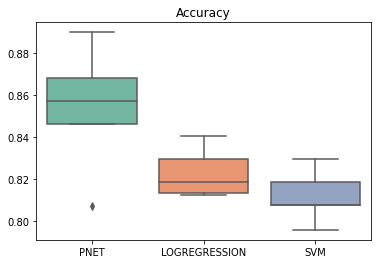

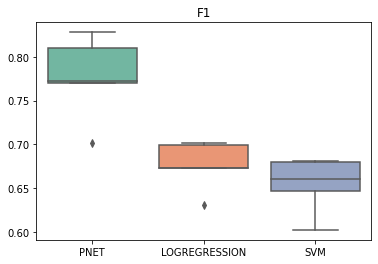

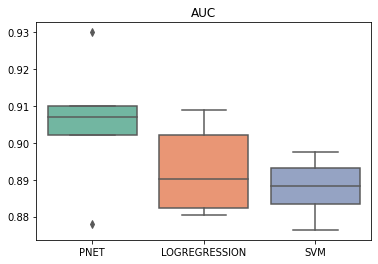

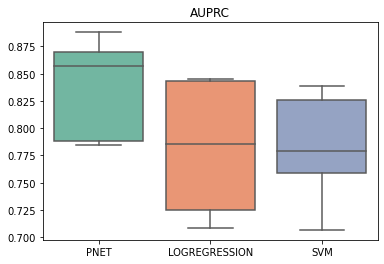

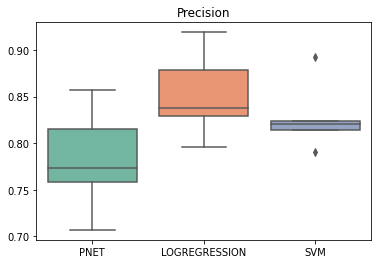

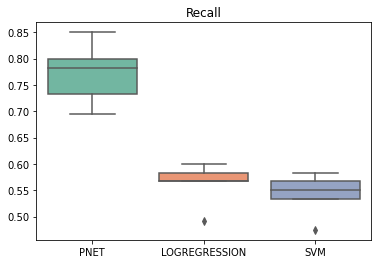

In [ ]:
evaluate_cv(precision_cv_pnet, recall_cv_pnet, accuracies_cv_pnet, f1s_cv_pnet, aucs_cv_pnet, auprcs_cv_pnet, precision_cv_logreg, recall_cv_logreg, accuracies_cv_logreg, f1s_cv_logreg, aucs_cv_logreg, auprcs_cv_logreg,precision_cv_svm, recall_cv_svm, accuracies_cv_svm, f1s_cv_svm, aucs_cv_svm, auprcs_cv_svm)

# Number of samples (P-NET and Dense)

## Load data

In [ ]:
# Load data
params_file_ns_pnet = '/content/gdrive/My Drive/ECBM4060/pnet_finalproject/pnet_prostate_paper/train/params/P1000/number_samples/crossvalidation_average_reg_10.py'
params_ns_pnet = imp.load_source('crossvalidation_average_reg_10', params_file_ns_pnet)

/content/gdrive/My Drive/ECBM4060/pnet_finalproject/pnet_prostate_paper/train/params/P1000


In [ ]:
params_ns_pnet.data

[{'id': 'data_0',
  'params': {'balanced_data': False,
   'cnv_levels': 3,
   'combine_type': 'union',
   'data_type': ['mut_important', 'cnv_del', 'cnv_amp'],
   'drop_AR': False,
   'mut_binary': True,
   'selected_genes': 'tcga_prostate_expressed_genes_and_cancer_genes.csv',
   'training_split': '0',
   'use_coding_genes_only': True},
  'type': 'prostate_paper'},
 {'id': 'data_3',
  'params': {'balanced_data': False,
   'cnv_levels': 3,
   'combine_type': 'union',
   'data_type': ['mut_important', 'cnv_del', 'cnv_amp'],
   'drop_AR': False,
   'mut_binary': True,
   'selected_genes': 'tcga_prostate_expressed_genes_and_cancer_genes.csv',
   'training_split': '3',
   'use_coding_genes_only': True},
  'type': 'prostate_paper'},
 {'id': 'data_6',
  'params': {'balanced_data': False,
   'cnv_levels': 3,
   'combine_type': 'union',
   'data_type': ['mut_important', 'cnv_del', 'cnv_amp'],
   'drop_AR': False,
   'mut_binary': True,
   'selected_genes': 'tcga_prostate_expressed_genes_and_ca

In [ ]:
# Choose 3 number of samples (3 splits, 9 splits, and 15 splits)
data_params_ns1 = params_ns_pnet.data[1]
data_ns1 = Data(**data_params_ns1)

data_params_ns2 = params_ns_pnet.data[3]
data_ns2 = Data(**data_params_ns2)

data_params_ns3 = params_ns_pnet.data[5]
data_ns3 = Data(**data_params_ns3)

In [ ]:
# Cross-validation
x_train_ns1, x_validate_ns1, x_test_ns1, y_train_ns1, y_validate_ns1, y_test_ns1, info_train_ns1, info_validate_ns1, info_test_ns1, cols_ns1 = data_ns1.get_train_validate_test()

x_train_ns2, x_validate_ns2, x_test_ns2, y_train_ns2, y_validate_ns2, y_test_ns2, info_train_ns2, info_validate_ns2, info_test_ns2, cols_ns2 = data_ns2.get_train_validate_test()

x_train_ns3, x_validate_ns3, x_test_ns3, y_train_ns3, y_validate_ns3, y_test_ns3, info_train_ns3, info_validate_ns3, info_test_ns3, cols_ns3 = data_ns3.get_train_validate_test()

In [ ]:
X_ns1 = np.concatenate((x_train_ns1, x_validate_ns1), axis=0)
y_ns1 = np.concatenate((y_train_ns1, y_validate_ns1), axis=0)
info_ns1 = np.concatenate((info_train_ns1, info_validate_ns1), axis=0)

X_ns2 = np.concatenate((x_train_ns2, x_validate_ns2), axis=0)
y_ns2 = np.concatenate((y_train_ns2, y_validate_ns2), axis=0)
info_ns2 = np.concatenate((info_train_ns2, info_validate_ns2), axis=0)

X_ns3 = np.concatenate((x_train_ns3, x_validate_ns3), axis=0)
y_ns3 = np.concatenate((y_train_ns3, y_validate_ns3), axis=0)
info_ns3 = np.concatenate((info_train_ns3, info_validate_ns3), axis=0)

In [ ]:
n_splits = params_ns_pnet.pipeline['params']['n_splits']
print("Number of folds: {}".format(n_splits))

Number of folds: 5


In [ ]:
skf = StratifiedKFold(n_splits=n_splits, random_state=123, shuffle=True)

## Build and train PNET

Train split = 3

In [ ]:
params_ns_pnet.models[1]

{'id': 'P-net',
 'params': {'build_fn': <function model.builders.prostate_models.build_pnet2>,
  'feature_importance': 'deepexplain_grad*input',
  'fitting_params': {'batch_size': 50,
   'class_weight': 'auto',
   'debug': False,
   'early_stop': False,
   'epoch': 300,
   'lr': 0.001,
   'monitor': 'val_o6_f1',
   'n_outputs': 6,
   'prediction_output': 'average',
   'reduce_lr': False,
   'reduce_lr_after_nepochs': {'drop': 0.25, 'epochs_drop': 50},
   'samples_per_epoch': 10,
   'save_gradient': False,
   'save_name': 'pnet',
   'select_best_model': False,
   'shuffle': True,
   'verbose': 2},
  'model_params': {'activation': 'selu',
   'add_unk_genes': False,
   'attention': False,
   'data_params': {'id': 'ALL',
    'params': {'balanced_data': False,
     'cnv_levels': 3,
     'combine_type': 'union',
     'data_type': ['mut_important', 'cnv_del', 'cnv_amp'],
     'drop_AR': False,
     'mut_binary': True,
     'selected_genes': 'tcga_prostate_expressed_genes_and_cancer_genes.csv'

In [ ]:
m_ns_pnet = params_ns_pnet.models[1]
model_params_ns_pnet = deepcopy(m_ns_pnet)
set_random_seeds(random_seed=10)

In [ ]:
fold = 0
accuracies_ns_pnet1 = []
f1s_ns_pnet1 = []
aucs_ns_pnet1 = []
auprcs_ns_pnet1 = []
precision_ns_pnet1 = []
recall_ns_pnet1 = []
for train_index, test_index in skf.split(X_ns1, y_ns1.ravel()):
  print('Training for fold {}'.format(fold))
  model_ns_pnet = nn.Model(**model_params_ns_pnet['params'])
  x_train1, x_test1 = X_ns1[train_index], X_ns1[test_index]
  y_train1, y_test1 = y_ns1[train_index], y_ns1[test_index]
  info_train1 = pd.DataFrame(index=info_ns1[train_index])
  info_test1 = pd.DataFrame(index=info_ns1[test_index])
  print('Shape of x_train {}'.format(np.shape(x_train1)))
  print('shame of x_test {}'.format(np.shape(x_test1)))
  model_ns_pnet = model_ns_pnet.fit(x_train1, y_train1)
  y_pred_test_ns_pnet1 = model_ns_pnet.predict(x_test1)
  y_pred_score_ns_pnet1 = model_ns_pnet.predict_proba(x_test1)[:,1]
  acc, f1, auc_score, auprc, p, r = evaluate_fold(y_test1, y_pred_test_ns_pnet1, y_pred_score_ns_pnet1)
  accuracies_ns_pnet1.append(acc)
  f1s_ns_pnet1.append(f1)
  aucs_ns_pnet1.append(auc_score)
  auprcs_ns_pnet1.append(auprc)
  precision_ns_pnet1.append(p)
  recall_ns_pnet1.append(r)
  fold +=1

Training for fold 0
auto
Shape of x_train (544, 27687)
shame of x_test (137, 27687)
{'id': 'ALL', 'type': 'prostate_paper', 'params': {'data_type': ['mut_important', 'cnv_del', 'cnv_amp'], 'drop_AR': False, 'cnv_levels': 3, 'mut_binary': True, 'balanced_data': False, 'combine_type': 'union', 'use_coding_genes_only': True, 'selected_genes': 'tcga_prostate_expressed_genes_and_cancer_genes.csv', 'training_split': 10}}
n_hidden_layers 5


(1011, 27687)
(1011, 1)
(1011,)
(27687,)
input dimension 27687 self.units 9229
n_inputs_per_node 3.0
self.kernel_initializer <keras.regularizers.L1L2 object at 0x7f48f5d11750> <keras.initializers.VarianceScaling object at 0x7f48f6eeeb50> <keras.regularizers.L1L2 object at 0x7f48f5d11750>
input dimensions (?, 27687)
layer # 0
pathways 1387
genes 9275
filtered_map (9229, 0)
filtered_map (9229, 0)
filtered_map (9229, 0)
layer # 1
pathways 1066
genes 1399
filtered_map (1387, 0)
filtered_map (1387, 0)
filtered_map (1387, 0)
layer # 2
pathways 447
genes 1068
filtered_map (1066, 0)
filtered_map (1066, 0)
filtered_map (1066, 0)
layer # 3
pathways 147
genes 448
filtered_map (447, 0)
filtered_map (447, 0)
filtered_map (447, 0)
layer # 4
pathways 26
genes 147
filtered_map (147, 0)
filtered_map (147, 0)
filtered_map (147, 0)
layer # 5
pathways 1
genes 26
filtered_map (26, 0)
filtered_map (26, 0)
filtered_map (26, 0)
original dropout [0.5, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
dropout range(1, 6) [0.5, 0.1

(137, 1)
(137, 2)
Precision: 0.929
Recall: 0.578
Accuracy: 0.847
F1 Score: 0.712
AUC Score: 0.864
AUPRC Score: 0.834

Training for fold 1
auto
Shape of x_train (545, 27687)
shame of x_test (136, 27687)
{'id': 'ALL', 'type': 'prostate_paper', 'params': {'data_type': ['mut_important', 'cnv_del', 'cnv_amp'], 'drop_AR': False, 'cnv_levels': 3, 'mut_binary': True, 'balanced_data': False, 'combine_type': 'union', 'use_coding_genes_only': True, 'selected_genes': 'tcga_prostate_expressed_genes_and_cancer_genes.csv', 'training_split': 10}}
n_hidden_layers 5


(1011, 27687)
(1011, 1)
(1011,)
(27687,)
input dimension 27687 self.units 9229
n_inputs_per_node 3.0
self.kernel_initializer <keras.regularizers.L1L2 object at 0x7f48f0305b50> <keras.initializers.VarianceScaling object at 0x7f48f03057d0> <keras.regularizers.L1L2 object at 0x7f48f0305b50>
input dimensions (?, 27687)
layer # 0
pathways 1387
genes 9275
filtered_map (9229, 0)
filtered_map (9229, 0)
filtered_map (9229, 0)
layer # 1
pathways 1066
genes 1399
filtered_map (1387, 0)
filtered_map (1387, 0)
filtered_map (1387, 0)
layer # 2
pathways 447
genes 1068
filtered_map (1066, 0)
filtered_map (1066, 0)
filtered_map (1066, 0)
layer # 3
pathways 147
genes 448
filtered_map (447, 0)
filtered_map (447, 0)
filtered_map (447, 0)
layer # 4
pathways 26
genes 147
filtered_map (147, 0)
filtered_map (147, 0)
filtered_map (147, 0)
layer # 5
pathways 1
genes 26
filtered_map (26, 0)
filtered_map (26, 0)
filtered_map (26, 0)
original dropout [0.5, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
dropout range(1, 6) [0.5, 0.1

(136, 1)
(136, 2)
Precision: 0.806
Recall: 0.644
Accuracy: 0.831
F1 Score: 0.716
AUC Score: 0.911
AUPRC Score: 0.811

Training for fold 2
auto
Shape of x_train (545, 27687)
shame of x_test (136, 27687)
{'id': 'ALL', 'type': 'prostate_paper', 'params': {'data_type': ['mut_important', 'cnv_del', 'cnv_amp'], 'drop_AR': False, 'cnv_levels': 3, 'mut_binary': True, 'balanced_data': False, 'combine_type': 'union', 'use_coding_genes_only': True, 'selected_genes': 'tcga_prostate_expressed_genes_and_cancer_genes.csv', 'training_split': 10}}
n_hidden_layers 5


(1011, 27687)
(1011, 1)
(1011,)
(27687,)
input dimension 27687 self.units 9229
n_inputs_per_node 3.0
self.kernel_initializer <keras.regularizers.L1L2 object at 0x7f48ebec9e50> <keras.initializers.VarianceScaling object at 0x7f48ebec9990> <keras.regularizers.L1L2 object at 0x7f48ebec9e50>
input dimensions (?, 27687)
layer # 0
pathways 1387
genes 9275
filtered_map (9229, 0)
filtered_map (9229, 0)
filtered_map (9229, 0)
layer # 1
pathways 1066
genes 1399
filtered_map (1387, 0)
filtered_map (1387, 0)
filtered_map (1387, 0)
layer # 2
pathways 447
genes 1068
filtered_map (1066, 0)
filtered_map (1066, 0)
filtered_map (1066, 0)
layer # 3
pathways 147
genes 448
filtered_map (447, 0)
filtered_map (447, 0)
filtered_map (447, 0)
layer # 4
pathways 26
genes 147
filtered_map (147, 0)
filtered_map (147, 0)
filtered_map (147, 0)
layer # 5
pathways 1
genes 26
filtered_map (26, 0)
filtered_map (26, 0)
filtered_map (26, 0)
original dropout [0.5, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
dropout range(1, 6) [0.5, 0.1

(136, 1)
(136, 2)
Precision: 0.875
Recall: 0.622
Accuracy: 0.846
F1 Score: 0.727
AUC Score: 0.893
AUPRC Score: 0.821

Training for fold 3
auto
Shape of x_train (545, 27687)
shame of x_test (136, 27687)
{'id': 'ALL', 'type': 'prostate_paper', 'params': {'data_type': ['mut_important', 'cnv_del', 'cnv_amp'], 'drop_AR': False, 'cnv_levels': 3, 'mut_binary': True, 'balanced_data': False, 'combine_type': 'union', 'use_coding_genes_only': True, 'selected_genes': 'tcga_prostate_expressed_genes_and_cancer_genes.csv', 'training_split': 10}}
n_hidden_layers 5


(1011, 27687)
(1011, 1)
(1011,)
(27687,)
input dimension 27687 self.units 9229
n_inputs_per_node 3.0
self.kernel_initializer <keras.regularizers.L1L2 object at 0x7f48e7aacf10> <keras.initializers.VarianceScaling object at 0x7f48e7aab190> <keras.regularizers.L1L2 object at 0x7f48e7aacf10>
input dimensions (?, 27687)
layer # 0
pathways 1387
genes 9275
filtered_map (9229, 0)
filtered_map (9229, 0)
filtered_map (9229, 0)
layer # 1
pathways 1066
genes 1399
filtered_map (1387, 0)
filtered_map (1387, 0)
filtered_map (1387, 0)
layer # 2
pathways 447
genes 1068
filtered_map (1066, 0)
filtered_map (1066, 0)
filtered_map (1066, 0)
layer # 3
pathways 147
genes 448
filtered_map (447, 0)
filtered_map (447, 0)
filtered_map (447, 0)
layer # 4
pathways 26
genes 147
filtered_map (147, 0)
filtered_map (147, 0)
filtered_map (147, 0)
layer # 5
pathways 1
genes 26
filtered_map (26, 0)
filtered_map (26, 0)
filtered_map (26, 0)
original dropout [0.5, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
dropout range(1, 6) [0.5, 0.1

(136, 1)
(136, 2)
Precision: 0.857
Recall: 0.667
Accuracy: 0.853
F1 Score: 0.750
AUC Score: 0.897
AUPRC Score: 0.847

Training for fold 4
auto
Shape of x_train (545, 27687)
shame of x_test (136, 27687)
{'id': 'ALL', 'type': 'prostate_paper', 'params': {'data_type': ['mut_important', 'cnv_del', 'cnv_amp'], 'drop_AR': False, 'cnv_levels': 3, 'mut_binary': True, 'balanced_data': False, 'combine_type': 'union', 'use_coding_genes_only': True, 'selected_genes': 'tcga_prostate_expressed_genes_and_cancer_genes.csv', 'training_split': 10}}
n_hidden_layers 5


(1011, 27687)
(1011, 1)
(1011,)
(27687,)
input dimension 27687 self.units 9229
n_inputs_per_node 3.0
self.kernel_initializer <keras.regularizers.L1L2 object at 0x7f48e3652890> <keras.initializers.VarianceScaling object at 0x7f48e3651290> <keras.regularizers.L1L2 object at 0x7f48e3652890>
input dimensions (?, 27687)
layer # 0
pathways 1387
genes 9275
filtered_map (9229, 0)
filtered_map (9229, 0)
filtered_map (9229, 0)
layer # 1
pathways 1066
genes 1399
filtered_map (1387, 0)
filtered_map (1387, 0)
filtered_map (1387, 0)
layer # 2
pathways 447
genes 1068
filtered_map (1066, 0)
filtered_map (1066, 0)
filtered_map (1066, 0)
layer # 3
pathways 147
genes 448
filtered_map (447, 0)
filtered_map (447, 0)
filtered_map (447, 0)
layer # 4
pathways 26
genes 147
filtered_map (147, 0)
filtered_map (147, 0)
filtered_map (147, 0)
layer # 5
pathways 1
genes 26
filtered_map (26, 0)
filtered_map (26, 0)
filtered_map (26, 0)
original dropout [0.5, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
dropout range(1, 6) [0.5, 0.1

Train split = 9

In [ ]:
fold = 0
accuracies_ns_pnet2 = []
f1s_ns_pnet2 = []
aucs_ns_pnet2 = []
auprcs_ns_pnet2 = []
precision_ns_pnet2 = []
recall_ns_pnet2 = []
for train_index, test_index in skf.split(X_ns2, y_ns2.ravel()):
  print('Training for fold {}'.format(fold))
  model_ns_pnet = nn.Model(**model_params_ns_pnet['params'])
  x_train2, x_test2 = X_ns2[train_index], X_ns2[test_index]
  y_train2, y_test2 = y_ns2[train_index], y_ns2[test_index]
  info_train2 = pd.DataFrame(index=info_ns2[train_index])
  info_test2 = pd.DataFrame(index=info_ns2[test_index])
  print('Shape of x_train {}'.format(np.shape(x_train2)))
  print('shame of x_test {}'.format(np.shape(x_test2)))
  model_ns_pnet = model_ns_pnet.fit(x_train2, y_train2)
  y_pred_test_ns_pnet2 = model_ns_pnet.predict(x_test2)
  y_pred_score_ns_pnet2 = model_ns_pnet.predict_proba(x_test2)[:,1]
  acc, f1, auc_score, auprc, p, r = evaluate_fold(y_test2, y_pred_test_ns_pnet2, y_pred_score_ns_pnet2)
  accuracies_ns_pnet2.append(acc)
  f1s_ns_pnet2.append(f1)
  aucs_ns_pnet2.append(auc_score)
  auprcs_ns_pnet2.append(auprc)
  precision_ns_pnet2.append(p)
  recall_ns_pnet2.append(r)
  fold +=1

Training for fold 0
auto
Shape of x_train (320, 27687)
shame of x_test (81, 27687)
{'id': 'ALL', 'type': 'prostate_paper', 'params': {'data_type': ['mut_important', 'cnv_del', 'cnv_amp'], 'drop_AR': False, 'cnv_levels': 3, 'mut_binary': True, 'balanced_data': False, 'combine_type': 'union', 'use_coding_genes_only': True, 'selected_genes': 'tcga_prostate_expressed_genes_and_cancer_genes.csv', 'training_split': 10}}
n_hidden_layers 5


(1011, 27687)
(1011, 1)
(1011,)
(27687,)
input dimension 27687 self.units 9229
n_inputs_per_node 3.0
self.kernel_initializer <keras.regularizers.L1L2 object at 0x7f48defd6990> <keras.initializers.VarianceScaling object at 0x7f48e36e64d0> <keras.regularizers.L1L2 object at 0x7f48defd6990>
input dimensions (?, 27687)
layer # 0
pathways 1387
genes 9275
filtered_map (9229, 0)
filtered_map (9229, 0)
filtered_map (9229, 0)
layer # 1
pathways 1066
genes 1399
filtered_map (1387, 0)
filtered_map (1387, 0)
filtered_map (1387, 0)
layer # 2
pathways 447
genes 1068
filtered_map (1066, 0)
filtered_map (1066, 0)
filtered_map (1066, 0)
layer # 3
pathways 147
genes 448
filtered_map (447, 0)
filtered_map (447, 0)
filtered_map (447, 0)
layer # 4
pathways 26
genes 147
filtered_map (147, 0)
filtered_map (147, 0)
filtered_map (147, 0)
layer # 5
pathways 1
genes 26
filtered_map (26, 0)
filtered_map (26, 0)
filtered_map (26, 0)
original dropout [0.5, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
dropout range(1, 6) [0.5, 0.1

Shape of x_train (321, 27687)
shame of x_test (80, 27687)
{'id': 'ALL', 'type': 'prostate_paper', 'params': {'data_type': ['mut_important', 'cnv_del', 'cnv_amp'], 'drop_AR': False, 'cnv_levels': 3, 'mut_binary': True, 'balanced_data': False, 'combine_type': 'union', 'use_coding_genes_only': True, 'selected_genes': 'tcga_prostate_expressed_genes_and_cancer_genes.csv', 'training_split': 10}}
n_hidden_layers 5


(1011, 27687)
(1011, 1)
(1011,)
(27687,)
input dimension 27687 self.units 9229
n_inputs_per_node 3.0
self.kernel_initializer <keras.regularizers.L1L2 object at 0x7f48db9adc90> <keras.initializers.VarianceScaling object at 0x7f48db9ac750> <keras.regularizers.L1L2 object at 0x7f48db9adc90>
input dimensions (?, 27687)
layer # 0
pathways 1387
genes 9275
filtered_map (9229, 0)
filtered_map (9229, 0)
filtered_map (9229, 0)
layer # 1
pathways 1066
genes 1399
filtered_map (1387, 0)
filtered_map (1387, 0)
filtered_map (1387, 0)
layer # 2
pathways 447
genes 1068
filtered_map (1066, 0)
filtered_map (1066, 0)
filtered_map (1066, 0)
layer # 3
pathways 147
genes 448
filtered_map (447, 0)
filtered_map (447, 0)
filtered_map (447, 0)
layer # 4
pathways 26
genes 147
filtered_map (147, 0)
filtered_map (147, 0)
filtered_map (147, 0)
layer # 5
pathways 1
genes 26
filtered_map (26, 0)
filtered_map (26, 0)
filtered_map (26, 0)
original dropout [0.5, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
dropout range(1, 6) [0.5, 0.1

Shape of x_train (321, 27687)
shame of x_test (80, 27687)
{'id': 'ALL', 'type': 'prostate_paper', 'params': {'data_type': ['mut_important', 'cnv_del', 'cnv_amp'], 'drop_AR': False, 'cnv_levels': 3, 'mut_binary': True, 'balanced_data': False, 'combine_type': 'union', 'use_coding_genes_only': True, 'selected_genes': 'tcga_prostate_expressed_genes_and_cancer_genes.csv', 'training_split': 10}}
n_hidden_layers 5


(1011, 27687)
(1011, 1)
(1011,)
(27687,)
input dimension 27687 self.units 9229
n_inputs_per_node 3.0
self.kernel_initializer <keras.regularizers.L1L2 object at 0x7f48d7566250> <keras.initializers.VarianceScaling object at 0x7f48d75650d0> <keras.regularizers.L1L2 object at 0x7f48d7566250>
input dimensions (?, 27687)
layer # 0
pathways 1387
genes 9275
filtered_map (9229, 0)
filtered_map (9229, 0)
filtered_map (9229, 0)
layer # 1
pathways 1066
genes 1399
filtered_map (1387, 0)
filtered_map (1387, 0)
filtered_map (1387, 0)
layer # 2
pathways 447
genes 1068
filtered_map (1066, 0)
filtered_map (1066, 0)
filtered_map (1066, 0)
layer # 3
pathways 147
genes 448
filtered_map (447, 0)
filtered_map (447, 0)
filtered_map (447, 0)
layer # 4
pathways 26
genes 147
filtered_map (147, 0)
filtered_map (147, 0)
filtered_map (147, 0)
layer # 5
pathways 1
genes 26
filtered_map (26, 0)
filtered_map (26, 0)
filtered_map (26, 0)
original dropout [0.5, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
dropout range(1, 6) [0.5, 0.1

Precision: 0.824
Recall: 0.538
Accuracy: 0.812
F1 Score: 0.651
AUC Score: 0.833
AUPRC Score: 0.777

Training for fold 3
auto
Shape of x_train (321, 27687)
shame of x_test (80, 27687)
{'id': 'ALL', 'type': 'prostate_paper', 'params': {'data_type': ['mut_important', 'cnv_del', 'cnv_amp'], 'drop_AR': False, 'cnv_levels': 3, 'mut_binary': True, 'balanced_data': False, 'combine_type': 'union', 'use_coding_genes_only': True, 'selected_genes': 'tcga_prostate_expressed_genes_and_cancer_genes.csv', 'training_split': 10}}
n_hidden_layers 5


(1011, 27687)
(1011, 1)
(1011,)
(27687,)
input dimension 27687 self.units 9229
n_inputs_per_node 3.0
self.kernel_initializer <keras.regularizers.L1L2 object at 0x7f48d2fa3a10> <keras.initializers.VarianceScaling object at 0x7f48d2fa2e50> <keras.regularizers.L1L2 object at 0x7f48d2fa3a10>
input dimensions (?, 27687)
layer # 0
pathways 1387
genes 9275
filtered_map (9229, 0)
filtered_map (9229, 0)
filtered_map (9229, 0)
layer # 1
pathways 1066
genes 1399
filtered_map (1387, 0)
filtered_map (1387, 0)
filtered_map (1387, 0)
layer # 2
pathways 447
genes 1068
filtered_map (1066, 0)
filtered_map (1066, 0)
filtered_map (1066, 0)
layer # 3
pathways 147
genes 448
filtered_map (447, 0)
filtered_map (447, 0)
filtered_map (447, 0)
layer # 4
pathways 26
genes 147
filtered_map (147, 0)
filtered_map (147, 0)
filtered_map (147, 0)
layer # 5
pathways 1
genes 26
filtered_map (26, 0)
filtered_map (26, 0)
filtered_map (26, 0)
original dropout [0.5, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
dropout range(1, 6) [0.5, 0.1

Shape of x_train (321, 27687)
shame of x_test (80, 27687)
{'id': 'ALL', 'type': 'prostate_paper', 'params': {'data_type': ['mut_important', 'cnv_del', 'cnv_amp'], 'drop_AR': False, 'cnv_levels': 3, 'mut_binary': True, 'balanced_data': False, 'combine_type': 'union', 'use_coding_genes_only': True, 'selected_genes': 'tcga_prostate_expressed_genes_and_cancer_genes.csv', 'training_split': 10}}
n_hidden_layers 5


(1011, 27687)
(1011, 1)
(1011,)
(27687,)
input dimension 27687 self.units 9229
n_inputs_per_node 3.0
self.kernel_initializer <keras.regularizers.L1L2 object at 0x7f48cece6190> <keras.initializers.VarianceScaling object at 0x7f48cece55d0> <keras.regularizers.L1L2 object at 0x7f48cece6190>
input dimensions (?, 27687)
layer # 0
pathways 1387
genes 9275
filtered_map (9229, 0)
filtered_map (9229, 0)
filtered_map (9229, 0)
layer # 1
pathways 1066
genes 1399
filtered_map (1387, 0)
filtered_map (1387, 0)
filtered_map (1387, 0)
layer # 2
pathways 447
genes 1068
filtered_map (1066, 0)
filtered_map (1066, 0)
filtered_map (1066, 0)
layer # 3
pathways 147
genes 448
filtered_map (447, 0)
filtered_map (447, 0)
filtered_map (447, 0)
layer # 4
pathways 26
genes 147
filtered_map (147, 0)
filtered_map (147, 0)
filtered_map (147, 0)
layer # 5
pathways 1
genes 26
filtered_map (26, 0)
filtered_map (26, 0)
filtered_map (26, 0)
original dropout [0.5, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
dropout range(1, 6) [0.5, 0.1

Train split = 15

In [ ]:
fold = 0
accuracies_ns_pnet3 = []
f1s_ns_pnet3 = []
aucs_ns_pnet3 = []
auprcs_ns_pnet3 = []
precision_ns_pnet3 = []
recall_ns_pnet3 = []
for train_index, test_index in skf.split(X_ns3, y_ns3.ravel()):
  print('Training for fold {}'.format(fold))
  model_ns_pnet = nn.Model(**model_params_ns_pnet['params'])
  x_train3, x_test3 = X_ns3[train_index], X_ns3[test_index]
  y_train3, y_test3 = y_ns3[train_index], y_ns3[test_index]
  info_train3 = pd.DataFrame(index=info_ns3[train_index])
  info_test3 = pd.DataFrame(index=info_ns3[test_index])
  print('Shape of x_train {}'.format(np.shape(x_train3)))
  print('shame of x_test {}'.format(np.shape(x_test3)))
  model_ns_pnet = model_ns_pnet.fit(x_train3, y_train3)
  y_pred_test_ns_pnet3 = model_ns_pnet.predict(x_test3)
  y_pred_score_ns_pnet3 = model_ns_pnet.predict_proba(x_test3)[:,1]
  acc, f1, auc_score, auprc, p, r = evaluate_fold(y_test3, y_pred_test_ns_pnet3, y_pred_score_ns_pnet3)
  accuracies_ns_pnet3.append(acc)
  f1s_ns_pnet3.append(f1)
  aucs_ns_pnet3.append(auc_score)
  auprcs_ns_pnet3.append(auprc)
  precision_ns_pnet3.append(p)
  recall_ns_pnet3.append(r)
  fold +=1

Training for fold 0
auto
Shape of x_train (204, 27687)
shame of x_test (52, 27687)
{'id': 'ALL', 'type': 'prostate_paper', 'params': {'data_type': ['mut_important', 'cnv_del', 'cnv_amp'], 'drop_AR': False, 'cnv_levels': 3, 'mut_binary': True, 'balanced_data': False, 'combine_type': 'union', 'use_coding_genes_only': True, 'selected_genes': 'tcga_prostate_expressed_genes_and_cancer_genes.csv', 'training_split': 10}}
n_hidden_layers 5


(1011, 27687)
(1011, 1)
(1011,)
(27687,)
input dimension 27687 self.units 9229
n_inputs_per_node 3.0
self.kernel_initializer <keras.regularizers.L1L2 object at 0x7f5bb620a790> <keras.initializers.VarianceScaling object at 0x7f5bb58cd110> <keras.regularizers.L1L2 object at 0x7f5bb620a790>
input dimensions (?, 27687)
layer # 0
pathways 1387
genes 9275
filtered_map (9229, 0)
filtered_map (9229, 0)
filtered_map (9229, 0)
layer # 1
pathways 1066
genes 1399
filtered_map (1387, 0)
filtered_map (1387, 0)
filtered_map (1387, 0)
layer # 2
pathways 447
genes 1068
filtered_map (1066, 0)
filtered_map (1066, 0)
filtered_map (1066, 0)
layer # 3
pathways 147
genes 448
filtered_map (447, 0)
filtered_map (447, 0)
filtered_map (447, 0)
layer # 4
pathways 26
genes 147
filtered_map (147, 0)
filtered_map (147, 0)
filtered_map (147, 0)
layer # 5
pathways 1
genes 26
filtered_map (26, 0)
filtered_map (26, 0)
filtered_map (26, 0)
original dropout [0.5, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
dropout range(1, 6) [0.5, 0.1

(52, 1)
(52, 2)
Precision: 1.000
Recall: 0.059
Accuracy: 0.692
F1 Score: 0.111
AUC Score: 0.894
AUPRC Score: 0.793

Training for fold 1
auto
Shape of x_train (205, 27687)
shame of x_test (51, 27687)
{'id': 'ALL', 'type': 'prostate_paper', 'params': {'data_type': ['mut_important', 'cnv_del', 'cnv_amp'], 'drop_AR': False, 'cnv_levels': 3, 'mut_binary': True, 'balanced_data': False, 'combine_type': 'union', 'use_coding_genes_only': True, 'selected_genes': 'tcga_prostate_expressed_genes_and_cancer_genes.csv', 'training_split': 10}}
n_hidden_layers 5


(1011, 27687)
(1011, 1)
(1011,)
(27687,)
input dimension 27687 self.units 9229
n_inputs_per_node 3.0
self.kernel_initializer <keras.regularizers.L1L2 object at 0x7f5bb1a07ad0> <keras.initializers.VarianceScaling object at 0x7f5bb1a06f50> <keras.regularizers.L1L2 object at 0x7f5bb1a07ad0>
input dimensions (?, 27687)
layer # 0
pathways 1387
genes 9275
filtered_map (9229, 0)
filtered_map (9229, 0)
filtered_map (9229, 0)
layer # 1
pathways 1066
genes 1399
filtered_map (1387, 0)
filtered_map (1387, 0)
filtered_map (1387, 0)
layer # 2
pathways 447
genes 1068
filtered_map (1066, 0)
filtered_map (1066, 0)
filtered_map (1066, 0)
layer # 3
pathways 147
genes 448
filtered_map (447, 0)
filtered_map (447, 0)
filtered_map (447, 0)
layer # 4
pathways 26
genes 147
filtered_map (147, 0)
filtered_map (147, 0)
filtered_map (147, 0)
layer # 5
pathways 1
genes 26
filtered_map (26, 0)
filtered_map (26, 0)
filtered_map (26, 0)
original dropout [0.5, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
dropout range(1, 6) [0.5, 0.1

(51, 1)
(51, 2)
Precision: 0.750
Recall: 0.176
Accuracy: 0.706
F1 Score: 0.286
AUC Score: 0.829
AUPRC Score: 0.692

Training for fold 2
auto
Shape of x_train (205, 27687)
shame of x_test (51, 27687)
{'id': 'ALL', 'type': 'prostate_paper', 'params': {'data_type': ['mut_important', 'cnv_del', 'cnv_amp'], 'drop_AR': False, 'cnv_levels': 3, 'mut_binary': True, 'balanced_data': False, 'combine_type': 'union', 'use_coding_genes_only': True, 'selected_genes': 'tcga_prostate_expressed_genes_and_cancer_genes.csv', 'training_split': 10}}
n_hidden_layers 5


(1011, 27687)
(1011, 1)
(1011,)
(27687,)
input dimension 27687 self.units 9229
n_inputs_per_node 3.0
self.kernel_initializer <keras.regularizers.L1L2 object at 0x7f5bad8b5d50> <keras.initializers.VarianceScaling object at 0x7f5bad8b5350> <keras.regularizers.L1L2 object at 0x7f5bad8b5d50>
input dimensions (?, 27687)
layer # 0
pathways 1387
genes 9275
filtered_map (9229, 0)
filtered_map (9229, 0)
filtered_map (9229, 0)
layer # 1
pathways 1066
genes 1399
filtered_map (1387, 0)
filtered_map (1387, 0)
filtered_map (1387, 0)
layer # 2
pathways 447
genes 1068
filtered_map (1066, 0)
filtered_map (1066, 0)
filtered_map (1066, 0)
layer # 3
pathways 147
genes 448
filtered_map (447, 0)
filtered_map (447, 0)
filtered_map (447, 0)
layer # 4
pathways 26
genes 147
filtered_map (147, 0)
filtered_map (147, 0)
filtered_map (147, 0)
layer # 5
pathways 1
genes 26
filtered_map (26, 0)
filtered_map (26, 0)
filtered_map (26, 0)
original dropout [0.5, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
dropout range(1, 6) [0.5, 0.1

(51, 1)
(51, 2)
Precision: 1.000
Recall: 0.176
Accuracy: 0.725
F1 Score: 0.300
AUC Score: 0.877
AUPRC Score: 0.806

Training for fold 3
auto
Shape of x_train (205, 27687)
shame of x_test (51, 27687)
{'id': 'ALL', 'type': 'prostate_paper', 'params': {'data_type': ['mut_important', 'cnv_del', 'cnv_amp'], 'drop_AR': False, 'cnv_levels': 3, 'mut_binary': True, 'balanced_data': False, 'combine_type': 'union', 'use_coding_genes_only': True, 'selected_genes': 'tcga_prostate_expressed_genes_and_cancer_genes.csv', 'training_split': 10}}
n_hidden_layers 5


(1011, 27687)
(1011, 1)
(1011,)
(27687,)
input dimension 27687 self.units 9229
n_inputs_per_node 3.0
self.kernel_initializer <keras.regularizers.L1L2 object at 0x7f5ba981f490> <keras.initializers.VarianceScaling object at 0x7f5ba981f4d0> <keras.regularizers.L1L2 object at 0x7f5ba981f490>
input dimensions (?, 27687)
layer # 0
pathways 1387
genes 9275
filtered_map (9229, 0)
filtered_map (9229, 0)
filtered_map (9229, 0)
layer # 1
pathways 1066
genes 1399
filtered_map (1387, 0)
filtered_map (1387, 0)
filtered_map (1387, 0)
layer # 2
pathways 447
genes 1068
filtered_map (1066, 0)
filtered_map (1066, 0)
filtered_map (1066, 0)
layer # 3
pathways 147
genes 448
filtered_map (447, 0)
filtered_map (447, 0)
filtered_map (447, 0)
layer # 4
pathways 26
genes 147
filtered_map (147, 0)
filtered_map (147, 0)
filtered_map (147, 0)
layer # 5
pathways 1
genes 26
filtered_map (26, 0)
filtered_map (26, 0)
filtered_map (26, 0)
original dropout [0.5, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
dropout range(1, 6) [0.5, 0.1

(1011, 27687)
(1011, 1)
(1011,)
(27687,)
input dimension 27687 self.units 9229
n_inputs_per_node 3.0
self.kernel_initializer <keras.regularizers.L1L2 object at 0x7f5ba54cfb50> <keras.initializers.VarianceScaling object at 0x7f5ba54cd310> <keras.regularizers.L1L2 object at 0x7f5ba54cfb50>
input dimensions (?, 27687)
layer # 0
pathways 1387
genes 9275
filtered_map (9229, 0)
filtered_map (9229, 0)
filtered_map (9229, 0)
layer # 1
pathways 1066
genes 1399
filtered_map (1387, 0)
filtered_map (1387, 0)
filtered_map (1387, 0)
layer # 2
pathways 447
genes 1068
filtered_map (1066, 0)
filtered_map (1066, 0)
filtered_map (1066, 0)
layer # 3
pathways 147
genes 448
filtered_map (447, 0)
filtered_map (447, 0)
filtered_map (447, 0)
layer # 4
pathways 26
genes 147
filtered_map (147, 0)
filtered_map (147, 0)
filtered_map (147, 0)
layer # 5
pathways 1
genes 26
filtered_map (26, 0)
filtered_map (26, 0)
filtered_map (26, 0)
original dropout [0.5, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
dropout range(1, 6) [0.5, 0.1

## Build and train Dense

In [ ]:
def get_lr_metric(optimizer):  # printing the value of the learning rate
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

optimizer = tf.keras.optimizers.Adam()  
lr_metric = get_lr_metric(optimizer)

def scheduler(epoch):
    # Decrease the learning rate to 1/4 every 50 epochs
    initial_lr = 0.001
    drop = 0.25
    epochs_drop = 50
    lrate = initial_lr * math.pow(drop, math.floor((1+epoch)/epochs_drop))   
    return lrate

Train split = 3

In [ ]:
fold = 0
accuracies_ns_dense1 = []
f1s_ns_dense1 = []
aucs_ns_dense1 = []
auprcs_ns_dense1 = []
precision_ns_dense1 = []
recall_ns_dense1 = []
for train_index, test_index in skf.split(X_ns1, y_ns1.ravel()):
  print('Training for fold {}'.format(fold))
  x_train1, x_test1 = X_ns1[train_index], X_ns1[test_index]
  y_train1, y_test1 = y_ns1[train_index], y_ns1[test_index]
  info_train1 = pd.DataFrame(index=info_ns1[train_index])
  info_test1 = pd.DataFrame(index=info_ns1[test_index])
  print('Shape of x_train {}'.format(np.shape(x_train1)))
  print('shame of x_test {}'.format(np.shape(x_test1)))
  inputs = tf.keras.Input(shape=(x_train1.shape[1],), dtype='float32', name='inputs')
  layer1 = tf.keras.layers.Dense(units = int(np.ceil(float(71009) / float(x_train1.shape[1]))), activation='tanh', name="layer1", kernel_regularizer=l2(0.01))(inputs)# , input_shape=(x.shape[1],)
  outputs = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(layer1) 
  model_ns_dense = tf.keras.Model(inputs=inputs, outputs=outputs)
  model_ns_dense.compile(optimizer=optimizer,
                  loss='binary_crossentropy', metrics=['accuracy'])
  lrate = tf.keras.callbacks.LearningRateScheduler(scheduler)
  model_ns_dense.fit(
    x_train1,
    y_train1,
    batch_size = 50,
    epochs = 300,
    verbose = 2,
    shuffle=True,
    callbacks=[lrate],
    class_weight= 'auto',
    )
  y_pred_score_ns_dense1 = model_ns_dense.predict(x_test1)
  y_pred_test_ns_dense1 = np.array(list(map(int,y_pred_score_ns_dense1 > .5)))
  acc, f1, auc_score, auprc, p, r = evaluate_fold(y_test1, y_pred_test_ns_dense1, y_pred_score_ns_dense1)
  accuracies_ns_dense1.append(acc)
  f1s_ns_dense1.append(f1)
  aucs_ns_dense1.append(auc_score)
  auprcs_ns_dense1.append(auprc)
  precision_ns_dense1.append(p)
  recall_ns_dense1.append(r)
  fold +=1

Training for fold 0
Shape of x_train (544, 27687)
shame of x_test (137, 27687)
Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


Epoch 1/300
 - 0s - loss: 0.6870 - acc: 0.6452
Epoch 2/300
 - 0s - loss: 0.5271 - acc: 0.8842
Epoch 3/300
 - 0s - loss: 0.4640 - acc: 0.9522
Epoch 4/300
 - 0s - loss: 0.4234 - acc: 0.9779
Epoch 5/300
 - 0s - loss: 0.3953 - acc: 0.9853
Epoch 6/300
 - 0s - loss: 0.3741 - acc: 0.9908
Epoch 7/300
 - 0s - loss: 0.3574 - acc: 0.9926
Epoch 8/300
 - 0s - loss: 0.3441 - acc: 0.9926
Epoch 9/300
 - 0s - loss: 0.3330 - acc: 0.9926
Epoch 10/300
 - 0s - loss: 0.3216 - acc: 0.9945
Epoch 11/300
 - 0s - loss: 0.3130 - acc: 0.9945
Epoch 12/300
 - 0s - loss: 0.3051 - acc: 0.9963
Epoch 13/300
 - 0s - loss: 0.2983 - acc: 0.9945
Epoch 14/300
 - 0s - loss: 0.2921 - acc: 0.9963
Epoch 15/300
 - 0s - loss: 0.2863 - acc: 0.9963
Epoch 16/300
 - 0s - loss: 0.2810 - acc: 0.9963
Epoch 17/300
 - 0s - loss: 0.2760 - acc: 0.9963
Epoch 18/300
 - 0s - loss: 0.2715 - acc: 0.9963
Epoch 19/300
 - 0s - loss: 0.2665 - acc: 0.9963
Epoch 20/300
 - 0s - loss: 0.2625 - acc: 0.9963
Epoch 21/300
 - 0s - loss: 0.2581 - acc: 0.9963
E

Train split = 9

In [ ]:
fold = 0
accuracies_ns_dense2 = []
f1s_ns_dense2 = []
aucs_ns_dense2 = []
auprcs_ns_dense2 = []
precision_ns_dense2 = []
recall_ns_dense2 = []
for train_index, test_index in skf.split(X_ns2, y_ns2.ravel()):
  print('Training for fold {}'.format(fold))
  x_train2, x_test2 = X_ns2[train_index], X_ns2[test_index]
  y_train2, y_test2 = y_ns2[train_index], y_ns2[test_index]
  info_train2 = pd.DataFrame(index=info_ns2[train_index])
  info_test2 = pd.DataFrame(index=info_ns2[test_index])
  print('Shape of x_train {}'.format(np.shape(x_train2)))
  print('shame of x_test {}'.format(np.shape(x_test2)))
  inputs = tf.keras.Input(shape=(x_train2.shape[1],), dtype='float32', name='inputs')
  layer1 = tf.keras.layers.Dense(units = int(np.ceil(float(71009) / float(x_train2.shape[1]))), activation='tanh', name="layer1", kernel_regularizer=l2(0.01))(inputs)# , input_shape=(x.shape[1],)
  outputs = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(layer1) 
  model_ns_dense = tf.keras.Model(inputs=inputs, outputs=outputs)
  model_ns_dense.compile(optimizer=optimizer,
                  loss='binary_crossentropy', metrics=["accuracy"])
  lrate = tf.keras.callbacks.LearningRateScheduler(scheduler)
  model_ns_dense.fit(
    x_train2,
    y_train2,
    batch_size = 50,
    epochs = 300,
    verbose = 2,
    shuffle=True,
    callbacks=[lrate],
    class_weight= 'auto',
    )
  y_pred_score_ns_dense2 = model_ns_dense.predict(x_test2)
  y_pred_test_ns_dense2 = np.array(list(map(int,y_pred_score_ns_dense2 > .5)))
  acc, f1, auc_score, auprc, p, r = evaluate_fold(y_test2, y_pred_test_ns_dense2, y_pred_score_ns_dense2)
  accuracies_ns_dense2.append(acc)
  f1s_ns_dense2.append(f1)
  aucs_ns_dense2.append(auc_score)
  auprcs_ns_dense2.append(auprc)
  precision_ns_dense2.append(p)
  recall_ns_dense2.append(r)
  fold +=1

Training for fold 0
Shape of x_train (320, 27687)
shame of x_test (81, 27687)
Epoch 1/300
 - 0s - loss: 0.6990 - acc: 0.6500
Epoch 2/300
 - 0s - loss: 0.5117 - acc: 0.9406
Epoch 3/300
 - 0s - loss: 0.4530 - acc: 0.9812
Epoch 4/300
 - 0s - loss: 0.3994 - acc: 0.9875
Epoch 5/300
 - 0s - loss: 0.3603 - acc: 0.9875
Epoch 6/300
 - 0s - loss: 0.3317 - acc: 0.9906
Epoch 7/300
 - 0s - loss: 0.3113 - acc: 0.9906
Epoch 8/300
 - 0s - loss: 0.2923 - acc: 0.9906
Epoch 9/300
 - 0s - loss: 0.2779 - acc: 0.9906
Epoch 10/300
 - 0s - loss: 0.2671 - acc: 0.9906
Epoch 11/300
 - 0s - loss: 0.2561 - acc: 0.9906
Epoch 12/300
 - 0s - loss: 0.2474 - acc: 0.9906
Epoch 13/300
 - 0s - loss: 0.2398 - acc: 0.9906
Epoch 14/300
 - 0s - loss: 0.2335 - acc: 0.9937
Epoch 15/300
 - 0s - loss: 0.2252 - acc: 0.9937
Epoch 16/300
 - 0s - loss: 0.2164 - acc: 0.9937
Epoch 17/300
 - 0s - loss: 0.2090 - acc: 0.9937
Epoch 18/300
 - 0s - loss: 0.2046 - acc: 0.9937
Epoch 19/300
 - 0s - loss: 0.2005 - acc: 0.9937
Epoch 20/300
 - 0s 

Train split = 15

In [ ]:
fold = 0
accuracies_ns_dense3 = []
f1s_ns_dense3 = []
aucs_ns_dense3 = []
auprcs_ns_dense3 = []
precision_ns_dense3 = []
recall_ns_dense3 = []
for train_index, test_index in skf.split(X_ns3, y_ns3.ravel()):
  print('Training for fold {}'.format(fold))
  x_train3, x_test3 = X_ns3[train_index], X_ns3[test_index]
  y_train3, y_test3 = y_ns3[train_index], y_ns3[test_index]
  info_train3 = pd.DataFrame(index=info_ns3[train_index])
  info_test3 = pd.DataFrame(index=info_ns3[test_index])
  print('Shape of x_train {}'.format(np.shape(x_train3)))
  print('shame of x_test {}'.format(np.shape(x_test3)))
  inputs = tf.keras.Input(shape=(x_train3.shape[1],), dtype='float32', name='inputs')
  layer1 = tf.keras.layers.Dense(units = int(np.ceil(float(71009) / float(x_train3.shape[1]))), activation='tanh', name="layer1", kernel_regularizer=l2(0.01))(inputs)# , input_shape=(x.shape[1],)
  outputs = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(layer1) 
  model_ns_dense = tf.keras.Model(inputs=inputs, outputs=outputs)
  model_ns_dense.compile(optimizer=optimizer,
                  loss='binary_crossentropy', metrics=["accuracy"])
  lrate = tf.keras.callbacks.LearningRateScheduler(scheduler)
  model_ns_dense.fit(
    x_train3,
    y_train3,
    batch_size = 50,
    epochs = 300,
    verbose = 2,
    shuffle=True,
    callbacks=[lrate],
    class_weight= 'auto',
    )
  y_pred_score_ns_dense3 = model_ns_dense.predict(x_test3)
  y_pred_test_ns_dense3 = np.array(list(map(int,y_pred_score_ns_dense3 > .5)))  
  acc, f1, auc_score, auprc, p, r = evaluate_fold(y_test3, y_pred_test_ns_dense3, y_pred_score_ns_dense3)
  accuracies_ns_dense3.append(acc)
  f1s_ns_dense3.append(f1)
  aucs_ns_dense3.append(auc_score)
  auprcs_ns_dense3.append(auprc)
  precision_ns_dense3.append(p)
  recall_ns_dense3.append(r)
  fold +=1

Training for fold 0
Shape of x_train (204, 27687)
shame of x_test (52, 27687)
Epoch 1/300
 - 0s - loss: 0.6989 - acc: 0.6618
Epoch 2/300
 - 0s - loss: 0.5124 - acc: 0.9804
Epoch 3/300
 - 0s - loss: 0.4645 - acc: 0.9902
Epoch 4/300
 - 0s - loss: 0.4285 - acc: 0.9951
Epoch 5/300
 - 0s - loss: 0.3918 - acc: 0.9951
Epoch 6/300
 - 0s - loss: 0.3612 - acc: 0.9951
Epoch 7/300
 - 0s - loss: 0.3341 - acc: 1.0000
Epoch 8/300
 - 0s - loss: 0.3162 - acc: 1.0000
Epoch 9/300
 - 0s - loss: 0.2999 - acc: 1.0000
Epoch 10/300
 - 0s - loss: 0.2891 - acc: 1.0000
Epoch 11/300
 - 0s - loss: 0.2767 - acc: 1.0000
Epoch 12/300
 - 0s - loss: 0.2665 - acc: 1.0000
Epoch 13/300
 - 0s - loss: 0.2576 - acc: 1.0000
Epoch 14/300
 - 0s - loss: 0.2484 - acc: 1.0000
Epoch 15/300
 - 0s - loss: 0.2403 - acc: 1.0000
Epoch 16/300
 - 0s - loss: 0.2327 - acc: 1.0000
Epoch 17/300
 - 0s - loss: 0.2272 - acc: 1.0000
Epoch 18/300
 - 0s - loss: 0.2233 - acc: 1.0000
Epoch 19/300
 - 0s - loss: 0.2205 - acc: 1.0000
Epoch 20/300
 - 0s 

## Evaluation

In [ ]:
# Plots

def evaluation_plot_metric(metric_pnet1, metric_pnet2, metric_pnet3, metric_dense1, metric_dense2, metric_dense3, metric_name):
  x = [155, 300, 581]
  y1 = np.array([np.mean(metric_pnet1), np.mean(metric_pnet2), np.mean(metric_pnet2)])
  y2 = np.array([np.mean(metric_dense1), np.mean(metric_dense2), np.mean(metric_dense3)])

  dev1 = np.array([np.std(metric_pnet1), np.std(metric_pnet2), np.std(metric_pnet2)])
  dev2 = np.array([np.std(metric_dense1), np.std(metric_dense2), np.std(metric_dense3)])

  fig, ax = plt.subplots()
  ax.plot(x, y1, 'o-', label='P-NET')
  ax.fill_between(x, y1 - dev1, y1 + dev1, alpha=0.2)
  ax.plot(x, y2, 'o-', label='Dense')
  ax.fill_between(x, y2 - dev2, y2 + dev2, alpha=0.2)
  plt.title(metric_name)
  plt.xlabel('Number of samples')
  plt.ylabel(metric_name)
  plt.legend()

In [ ]:
# Train split = 3
pre_pnet1 = [0.929, 0.806, 0.875, 0.857, 0.921]
rec_pnet1 = [0.578, 0.644, 0.622, 0.667, 0.795]
acc_pnet1 = [0.847, 0.831, 0.846, 0.853, 0.912]
f1_pnet1 = [0.712, 0.716, 0.727, 0.750, 0.854]
AUC_pnet1 = [0.864, 0.911, 0.893, 0.897, 0.949]
AUPRC_pnet1 = [0.834, 0.811, 0.821, 0.847, 0.922]

# Train split = 9
pre_pnet2 = [0.812, 0.810, 0.824, 0.833, 0.944]
rec_pnet2 = [0.481, 0.630, 0.538, 0.577, 0.654]
acc_pnet2 = [0.790, 0.825, 0.812, 0.825, 0.875]
f1_pnet2 = [0.605, 0.708, 0.651, 0.682, 0.773]
AUC_pnet2 = [0.874, 0.876, 0.833, 0.880, 0.944]
AUPRC_pnet2 = [0.765, 0.799, 0.777, 0.808, 0.911]

# Train split = 15
pre_pnet3 = [1.000, 0.750, 1.000, 0.833, 0.833]
rec_pnet3 = [0.059, 0.176, 0.176, 0.294, 0.312]
acc_pnet3 = [0.692, 0.706, 0.725, 0.745, 0.765]
f1_pnet3 = [0.111, 0.286, 0.300, 0.435, 0.455]
AUC_pnet3 = [0.894, 0.829, 0.877, 0.813, 0.873]
AUPRC_pnet3 = [0.793, 0.692, 0.806, 0.757, 0.778]



In [ ]:
# Train split = 3
pre_dense1 = [0.889, 0.786, 0.871, 0.871, 0.824]
rec_dense1 = [0.356, 0.489, 0.600, 0.600, 0.636]
acc_dense1 = [0.774, 0.787, 0.838, 0.838, 0.838]
f1_dense1 = [0.508, 0.603, 0.711, 0.711, 0.718]
AUC_dense1 = [0.831, 0.875, 0.899, 0.895, 0.901]
AUPRC_dense1 = [0.771, 0.699, 0.810, 0.828, 0.811]

# Train split = 9
pre_dense2 = [0.692, 0.688, 0.750, 0.765, 0.846]
rec_dense2 = [0.333, 0.407, 0.462, 0.500, 0.423]
acc_dense2 = [0.728, 0.738, 0.775, 0.787, 0.787]
f1_dense2 = [0.450, 0.512, 0.571, 0.605, 0.564]
AUC_dense2 = [0.779, 0.804, 0.811, 0.814, 0.866]
AUPRC_dense2 = [0.618, 0.675, 0.767, 0.688, 0.800]

# Train split = 15
pre_dense3 = [0.833, 0.556, 0.833, 0.750, 0.667]
rec_dense3 = [0.294, 0.294, 0.294, 0.353, 0.250]
acc_dense3 = [0.750, 0.686, 0.745, 0.745, 0.725]
f1_dense3 = [0.435, 0.385, 0.435, 0.480, 0.364]
AUC_dense3 = [0.829, 0.763, 0.891, 0.782, 0.863]
AUPRC_dense3 = [0.744, 0.550, 0.774, 0.624, 0.745]

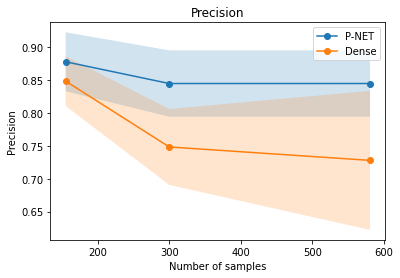

In [ ]:
# Precision
evaluation_plot_metric(pre_pnet1, pre_pnet2, pre_pnet3, pre_dense1, pre_dense2, pre_dense3, 'Precision')

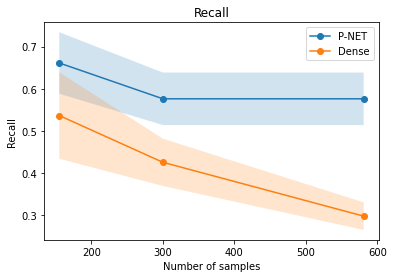

In [ ]:
# Recall
evaluation_plot_metric(rec_pnet1, rec_pnet2, rec_pnet3, rec_dense1, rec_dense2, rec_dense3, 'Recall')

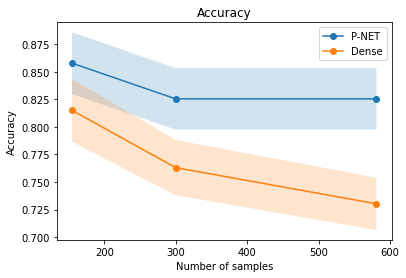

In [ ]:
# Accuracy
evaluation_plot_metric(acc_pnet1, acc_pnet2, acc_pnet3, acc_dense1, acc_dense2, acc_dense3, 'Accuracy')

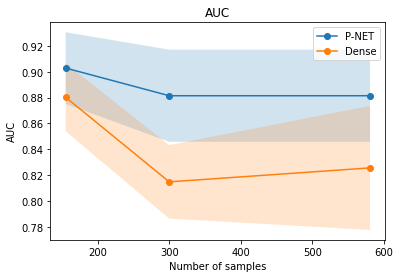

In [ ]:
# AUC
evaluation_plot_metric(AUC_pnet1, AUC_pnet2, AUC_pnet3, AUC_dense1, AUC_dense2, AUC_dense3, 'AUC')

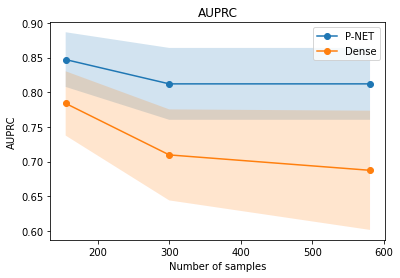

In [ ]:
# AUPRC
evaluation_plot_metric(AUPRC_pnet1, AUPRC_pnet2, AUPRC_pnet3, AUPRC_dense1, AUPRC_dense2, AUPRC_dense3, 'AUPRC')